# Creates an MS-COCO style dataset for powerpoint

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</s}tyle>"))

In [2]:
# win32 com
#http://www.s-anand.net/blog/automating-powerpoint-with-python/
#https://docs.microsoft.com/en-us/office/vba/api/powerpoint.fillformat.visible
import win32com.client
import os
import random
import numpy as np
import PIL
from tqdm import tqdm
import random 
import lib
import lib.ppt_interface
from natsort import natsorted
import cv2
import matplotlib.pyplot as plt

In [3]:
Application = win32com.client.Dispatch('PowerPoint.Application')
slide_height, slide_width = 540, 960
IMAGE_RES_DIVISOR = 1

In [4]:
part_x, part_y = (slide_height/IMAGE_RES_DIVISOR)/32, (slide_width/IMAGE_RES_DIVISOR)/32 
print(part_x*part_y, part_x, part_y)

506.25 16.875 30.0


In [29]:
from importlib import reload
reload(lib)
reload(lib.ppt_interface)
from lib.ppt_interface import PPT_shapes, add_shape, add_line, add_title, add_textBox, convert_line_xyhw_to_points, read_slide, write_slide
shape_manager = PPT_shapes()

In [69]:
def try_dir(path):
    try:
        os.makedirs(path)
    except Exception as e:
        print(e)
        pass

dataset = "custom"
train_path =  os.getcwd()+ f'\\data\\{dataset}\\train'
val_path =  os.getcwd()+ f'\\data\\{dataset}\\val'
path = val_path
deck_path = path + '/decks/'
try_dir(deck_path)

[WinError 183] Cannot create a file when that file already exists: 'C:\\Users\\Sholto Douglas\\Desktop\\artificial_graphics\\data\\custom\\val/decks/'


In [24]:

for p in natsorted(os.listdir(path+'/decks/')):
    if '~' in p: # don't want the intermediate checkpoints
        continue
    Presentation = Application.Presentations.Open(f'{path}\\decks\\' + p)
    
read_slide(Presentation.slides[4], shape_manager)

[{'left': 613.5628051757812,
  'top': 347.8130798339844,
  'height': 71.97393798828125,
  'width': 158.82347106933594,
  'fillRGB': array([0.90588235, 0.90196078, 0.90196078]),
  'border': 1,
  'fill': 1,
  'text': 0,
  'rotation': 0.0,
  'name': 'Rectangle',
  'class': 4},
 {'left': 66.0,
  'top': 28.75,
  'height': 104.37503814697266,
  'width': 828.0,
  'fillRGB': array([1., 1., 1.]),
  'border': 0,
  'fill': 0,
  'text': 1,
  'rotation': 0.0,
  'name': 'Title',
  'class': 0},
 {'left': 66.0,
  'top': 150.52944946289062,
  'height': 3,
  'width': 828.0,
  'fillRGB': array([0., 0., 0.]),
  'rotation': 0.0,
  'name': 'StraightConnector',
  'class': 2},
 {'left': 184.73928833007812,
  'top': 155.65101623535156,
  'height': 29.081260681152344,
  'width': 96.0,
  'fillRGB': array([1., 1., 1.]),
  'border': 0,
  'fill': 0,
  'text': 1,
  'rotation': 0.0,
  'name': 'TextBox',
  'class': 1},
 {'left': 66.0,
  'top': 336.9848937988281,
  'height': 29.081260681152344,
  'width': 96.0000762939

Creating


# Save images to disk

In [70]:
'''
Augmentations
'''
import time 
def canny(base_path, base_count, counter):
    img = cv2.imread(base_path+f"/{base_count}.jpg")
    img = 255 - cv2.Canny(img,100,200)
    plt.imsave(base_path+f"/{counter}.jpg", img, cmap='gray')
    return img

def sketch(base_path, base_count, counter):
    img = cv2.imread(base_path+f"/{base_count}.jpg")
    inverted_img = 255-cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blurred_img = 255-cv2.GaussianBlur(inverted_img, (7,7), 0)
    plt.imsave(base_path+f"/{counter}.jpg", blurred_img, cmap='gray')
    return blurred_img

def has_image(slide):
    for shape in slide.Shapes:
        name = "".join(shape.Name.split(' ')[:-1])
        if name == 'Picture':
            return True
    return False
    
    

In [71]:
images = []
annotations = []

counter = 0
anno_counter = 0

qal_augmentations = [_, canny, sketch]
sketch_augmentation = [_]


for p in natsorted(os.listdir(path+'/decks/')):
    if '~' in p: # don't want the intermediate checkpoints
        continue
    Presentation = Application.Presentations.Open(f'{path}\\decks\\' + p)
    # Make a dir for the images from tha
    for i,slide in tqdm(enumerate(Presentation.Slides)):
        readout = read_slide(slide, shape_manager)
        
#         [print(r) for r in readout]
        if has_image(slide):
            augs = sketch_augmentation
        else:
            augs = qal_augmentations
            
        for j, f in enumerate(augs):
            
            if j == 0:
                slide.Export(path+f"/{counter}.jpg", 'JPG', slide_width, slide_height)
            else:
                img = f(path, counter-j, counter) # we want to load the original img
                
        
            images.append({
                "id": counter,
                "file_name": f"{counter}.jpg",
                "width": slide_width,
                "height": slide_height,
                "date_captured":  "2021-06-20 01:55:23.687250",
                "license": 1,
                "coco_url": "",
                "flickr_url": "",
            })
            for anno in readout:
                annotations.append({
                    "id": anno_counter,
                    "image_id": counter,
                    "category_id": anno['class'],
                    "iscrowd": 0,
                    "area": anno['height']*anno['width'],
                    "bbox": [anno['left'], anno['top'], anno['width'], anno['height']],
                    "segmentation": [],
                    "angle": anno['rotation'],
                    "rotation": [np.cos(anno['rotation']*np.pi/180),np.sin(anno['rotation']*np.pi/180)],
                    "fill": list(anno['fillRGB']),

                })
                
                anno_counter += 1

            counter += 1
    Presentation.close()

19it [00:24,  1.28s/it]


In [72]:
import json
data =  {
    "info":           {
                      "description": "PPTAI",
                      "url": "sholtodouglas.github.io",
                      "version": "0.1.0",
                      "year": 2021,
                      "contributor": "sholtodouglas",
                      "date_created": "2021-06-20 01:55:39.314230"
                      },
    "licenses": [
                  {
                      "id": 1,
                      "name": "Mine",
                      "url": "Mine"
                  }
                ],
    "categories" : [],
    "images": images,
    "annotations": annotations,
}

for name, ID in shape_manager.classIDs.items():
    data['categories'].append({'id': ID, 'name':name, 'supercategory':"N/A"})
json_object = json.dumps(data, indent = 4)  
print(json_object) 

{
    "info": {
        "description": "PPTAI",
        "url": "sholtodouglas.github.io",
        "version": "0.1.0",
        "year": 2021,
        "contributor": "sholtodouglas",
        "date_created": "2021-06-20 01:55:39.314230"
    },
    "licenses": [
        {
            "id": 1,
            "name": "Mine",
            "url": "Mine"
        }
    ],
    "categories": [
        {
            "id": 0,
            "name": "Title",
            "supercategory": "N/A"
        },
        {
            "id": 1,
            "name": "TextBox",
            "supercategory": "N/A"
        },
        {
            "id": 2,
            "name": "StraightConnector",
            "supercategory": "N/A"
        },
        {
            "id": 3,
            "name": "StraightArrowConnector",
            "supercategory": "N/A"
        },
        {
            "id": 4,
            "name": "Rectangle",
            "supercategory": "N/A"
        },
        {
            "id": 5,
            "name": "Rou

In [74]:
if "train" in path:
    with open(f'{path}//custom_train.json', 'w') as f:
        json.dump(data, f)
else:
    with open(f'{path}//custom_val.json', 'w') as f:
        json.dump(data, f)

In [75]:
print(f"gsutil -m cp -r data/{dataset}/ gs://lfp_europe_west4_a/data/")

gsutil -m cp -r data/custom/ gs://lfp_europe_west4_a/data/


In [56]:
import torchvision
import os

class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(self, img_folder, feature_extractor, train=True):
        ann_file = os.path.join(img_folder, "custom_train.json" if train else "custom_val.json")
        super(CocoDetection, self).__init__(img_folder, ann_file)
        self.feature_extractor = feature_extractor

    def __getitem__(self, idx):
        # read in PIL image and target in COCO format
        img, target = super(CocoDetection, self).__getitem__(idx)
        
        # preprocess image and target (converting target to DETR format, resizing + normalization of both image and target)
        image_id = self.ids[idx]
        target = {'image_id': image_id, 'annotations': target}
        encoding = self.feature_extractor(images=img, annotations=target, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze() # remove batch dimension
        target = encoding["target"][0] # remove batch dimension

        return pixel_values, target

In [60]:
# Based on the class defined above, we create training and validation datasets.
from transformers import DetrFeatureExtractor

feature_extractor = DetrFeatureExtractor.from_pretrained("facebook/detr-resnet-50")

train_dataset = CocoDetection(img_folder=train_path, feature_extractor=feature_extractor)
val_dataset = CocoDetection(img_folder=val_path, feature_extractor=feature_extractor, train=False)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [61]:
import numpy as np
import os
from PIL import Image, ImageDraw
import math
# %%
from torch.utils.data import DataLoader

def collate_fn(batch):
  pixel_values = [item[0] for item in batch]
  encoding = feature_extractor.pad_and_create_pixel_mask(pixel_values, return_tensors="pt")
  labels = [item[1] for item in batch]
  batch = {}
  batch['pixel_values'] = encoding['pixel_values']
  batch['pixel_mask'] = encoding['pixel_mask']
  batch['labels'] = labels
  return batch

train_dataloader = DataLoader(train_dataset, collate_fn=collate_fn, batch_size=4, shuffle=True, num_workers = 3)
val_dataloader = DataLoader(val_dataset, collate_fn=collate_fn, batch_size=4, shuffle=True, num_workers = 3)

In [62]:
t_it = iter(train_dataloader)
batch = next(t_it)

RuntimeError: DataLoader worker (pid(s) 10192, 9076, 15548) exited unexpectedly

In [ ]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(val_dataset))

Image n°0
-0.396715128622563
[(882.0115485672834, -30.89383594638383), (841.6820066162495, -127.16260883874907), (77.9884514327166, 192.7688740933565), (118.31799338375049, 289.0376469857217)]
-0.24306777795596915
[(343.13506514636117, 570.6200700459825), (284.0428646192465, 332.3168669454167), (222.99193756970328, 347.45570510050186), (282.084138096818, 585.7589082010677)]
0.0
[(778.6539535522461, 353.0295181274414), (778.6539535522461, 124.7129898071289), (711.2062377929688, 124.7129898071289), (711.2062377929688, 353.0295181274414)]
0.4660988972660752
[(396.37319852873856, 211.64836861220408), (433.7110899078366, 137.4279838177107), (376.9279107852263, 108.86219046982718), (339.59001940612825, 183.08257526432055)]
-0.36807389636319804
[(508.5876790024582, 435.30327590210214), (446.42795243505356, 274.12112702482517), (395.5379885695633, 293.7467881848119), (457.69771513696793, 454.9289370620889)]
-0.27466671692197697
[(825.7195550545705, 398.75295825140597), (763.0795303010212, 176.

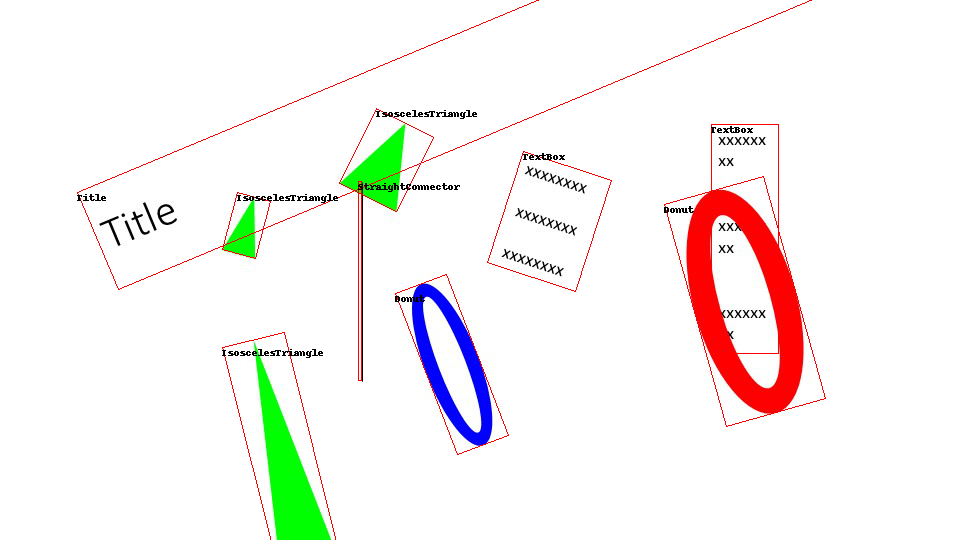

In [11]:
import numpy as np
import os
from PIL import Image, ImageDraw
import math

def makeRectangle(l, w, theta, offset=(0,0)):
    c, s = math.cos(theta), math.sin(theta)
    rectCoords = [(l/2.0, w/2.0), (l/2.0, -w/2.0), (-l/2.0, -w/2.0), (-l/2.0, w/2.0)]
    return [(c*x-s*y+offset[0], s*x+c*y+offset[1]) for (x,y) in rectCoords]

dataset = train_dataset
# based on https://github.com/woctezuma/finetune-detr/blob/master/finetune_detr.ipynb
image_ids = dataset.coco.getImgIds()
# let's pick a random image
image_id = 0# image_ids[np.random.randint(0, len(image_ids))]
print('Image n°{}'.format(image_id))
image = dataset.coco.loadImgs(image_id)[0]
image = Image.open(os.path.join(f'{DATA_BASE}/val', image['file_name']))

annotations = dataset.coco.imgToAnns[image_id]
draw = ImageDraw.Draw(image, "RGBA")

cats = dataset.coco.cats
id2label = {k: v['name'] for k,v in cats.items()}

for annotation in annotations:
  box = annotation['bbox']
  class_idx = annotation['category_id']
  x,y,w,h = tuple(box)
  #draw.rectangle((x,y,x+w,y+h), outline='red', width=1)
  v1,v2 = annotation['rotation']
  A  = np.arctan2(v2,v1)
  print(A)
  vertices = makeRectangle(w, h, A, offset=(x+w/2, y+h/2))  
  draw.polygon(vertices, outline='red')
  print(vertices)
  
  draw.text((vertices[2][0], vertices[2][1]), id2label[class_idx], fill='black')

image

In [123]:
annotation['rotation']

337.2698974609375

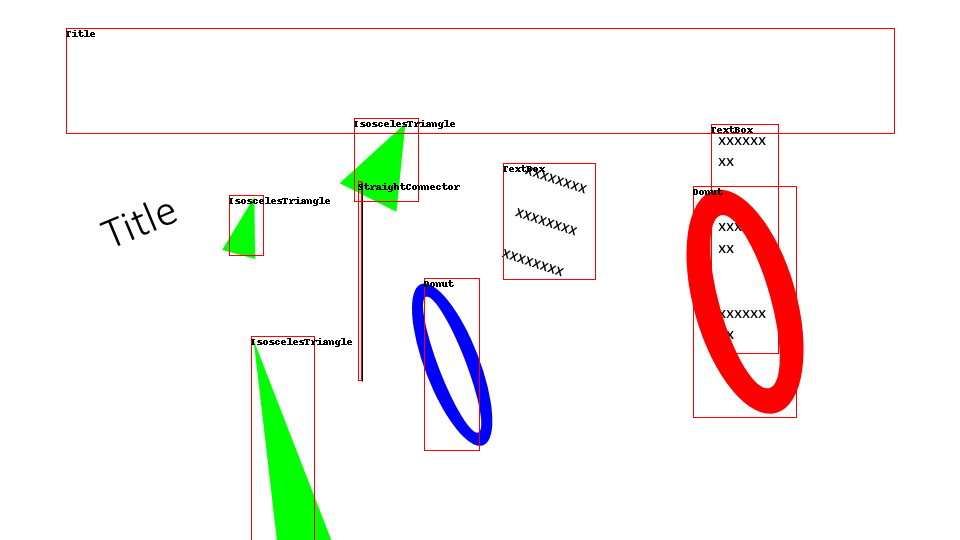

In [61]:
image

In [31]:
DATA_BASE = 'data/rgb_ppt/'
import os
import matplotlib.pyplot as plt


<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

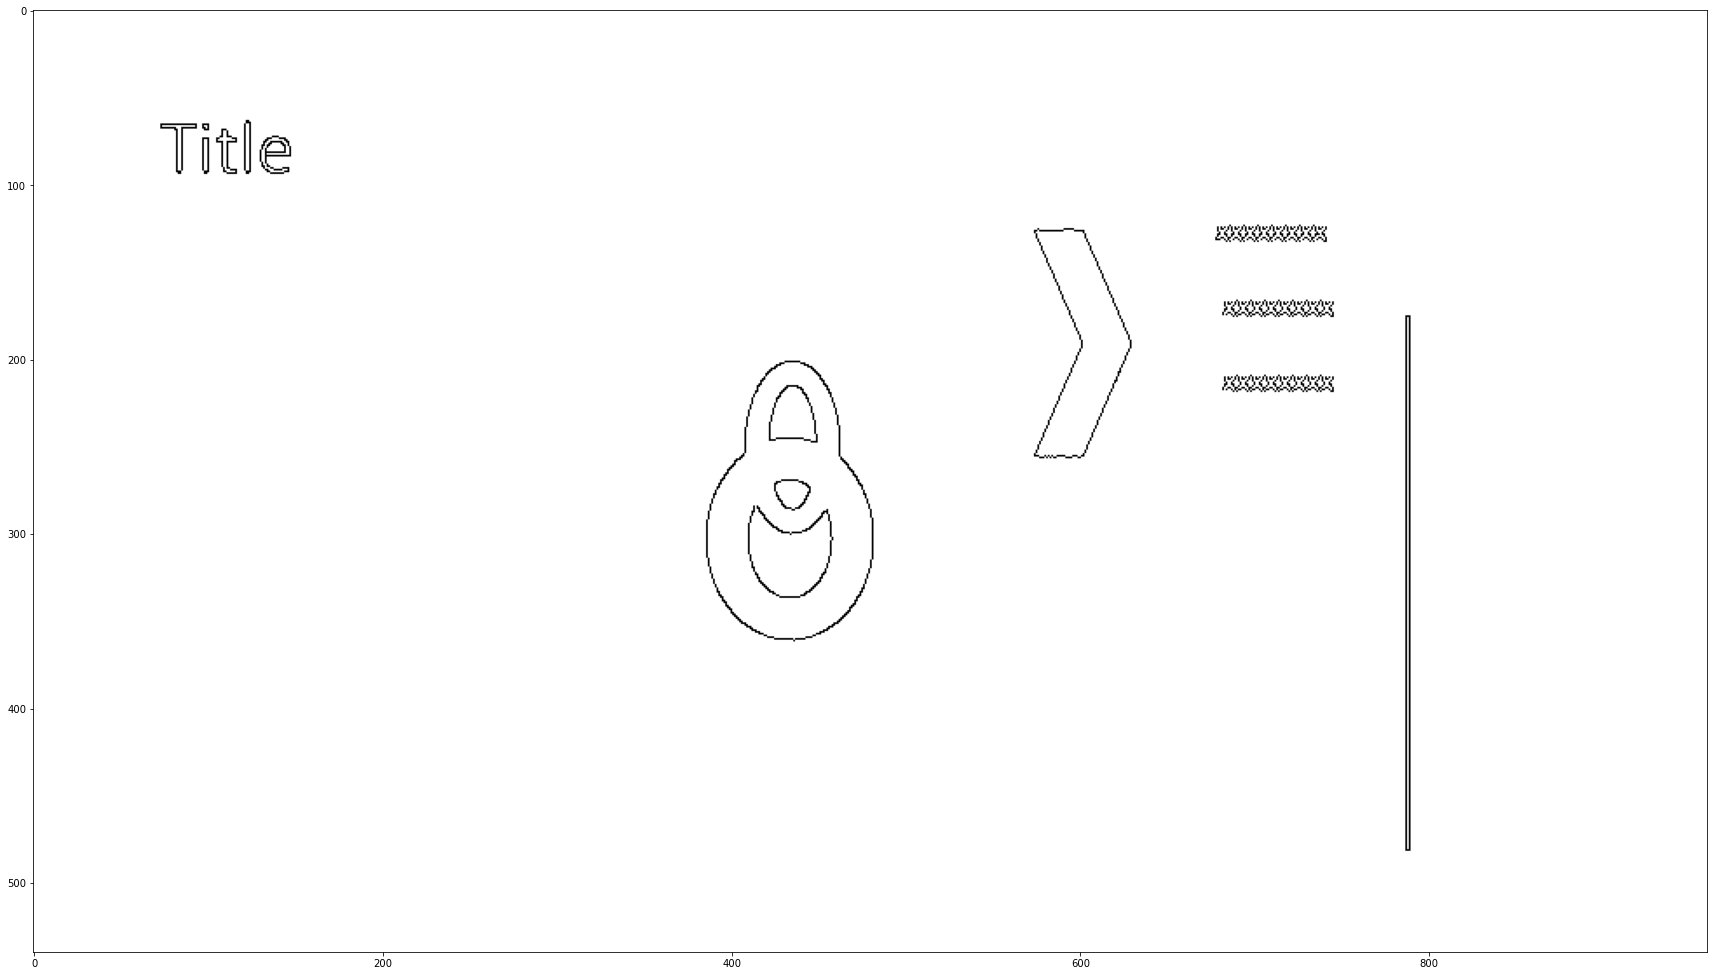

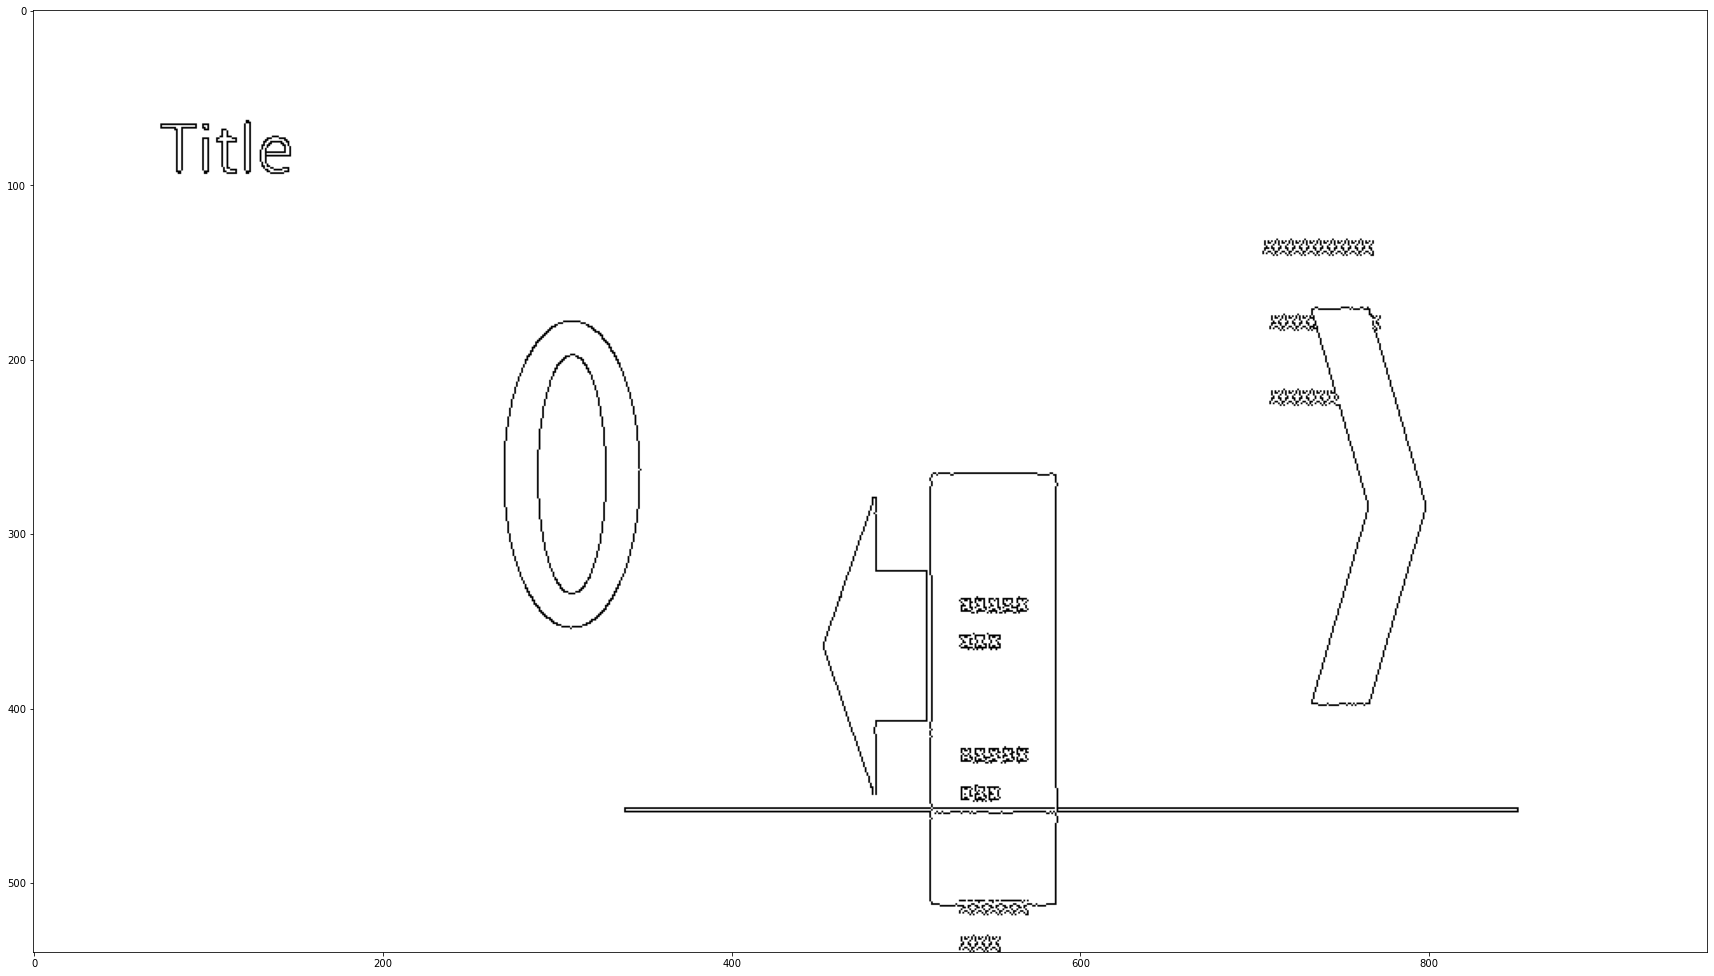

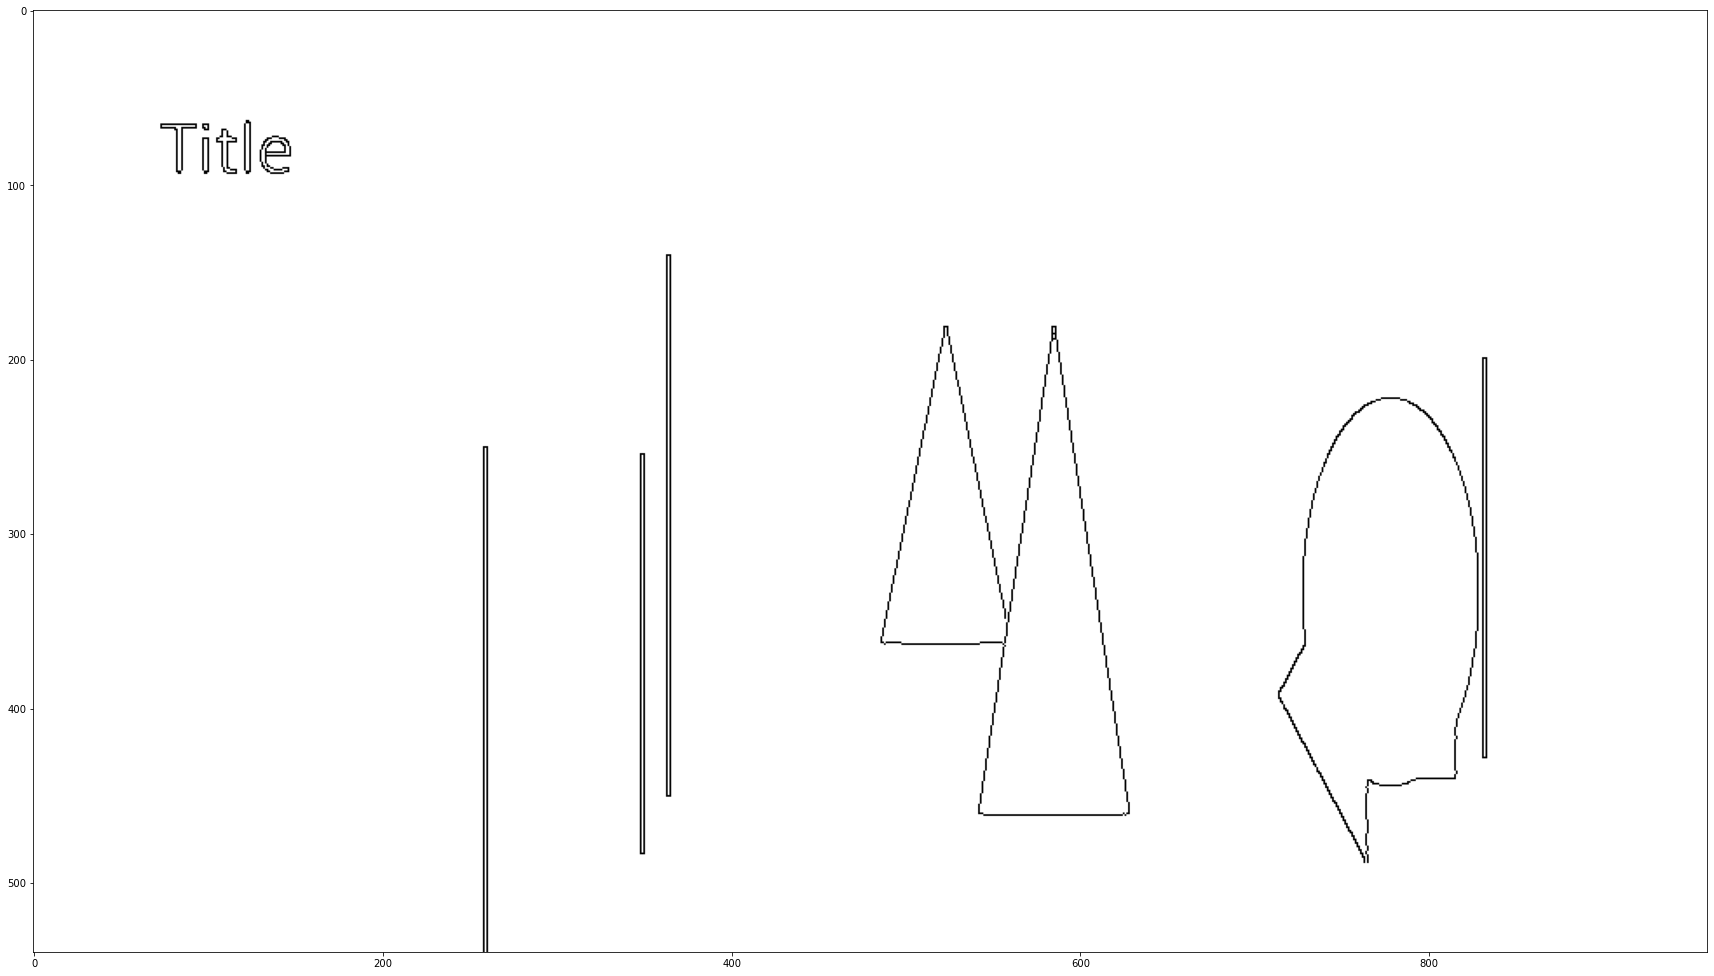

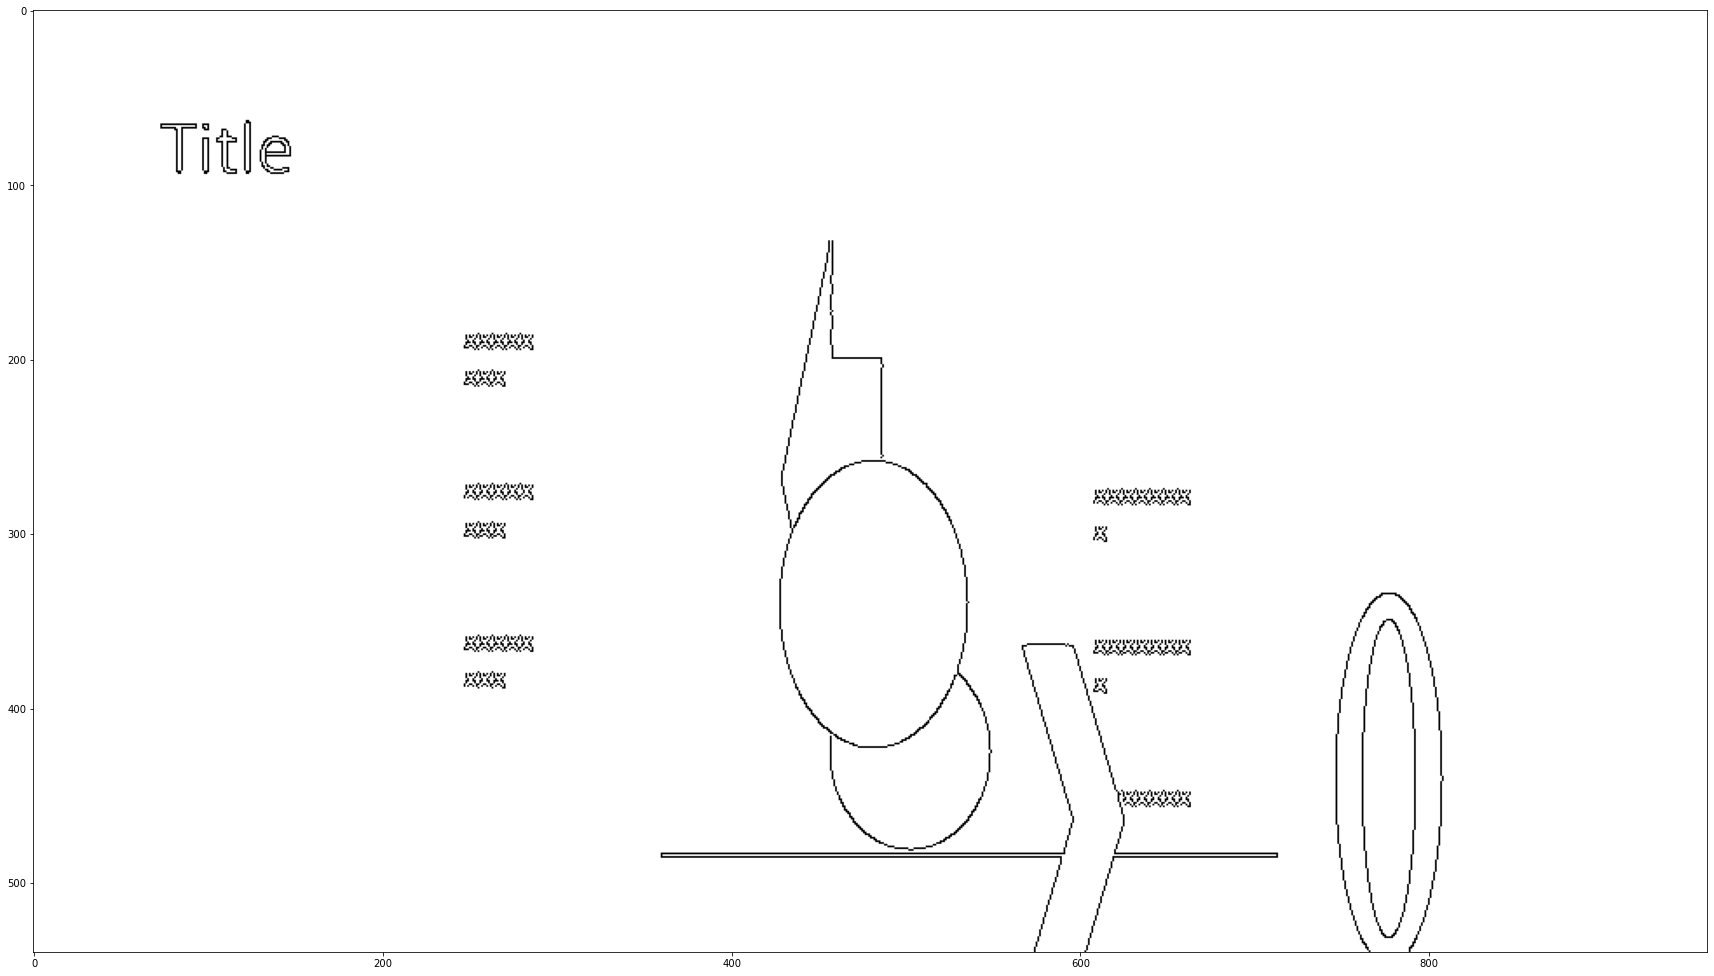

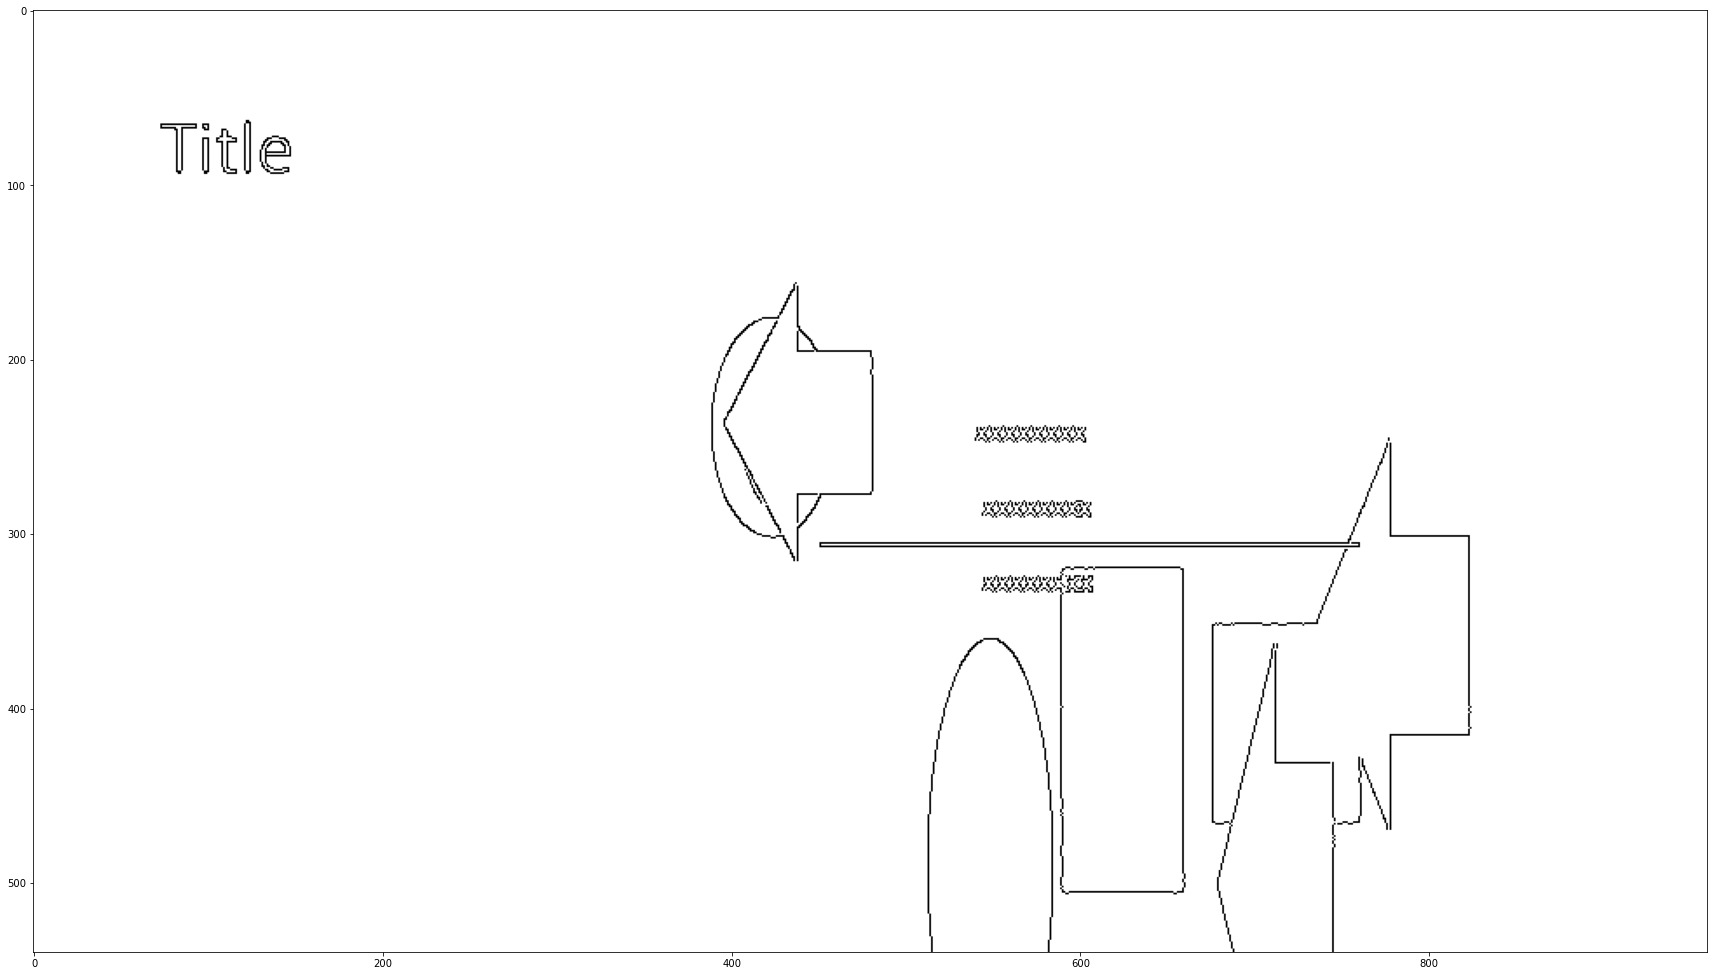

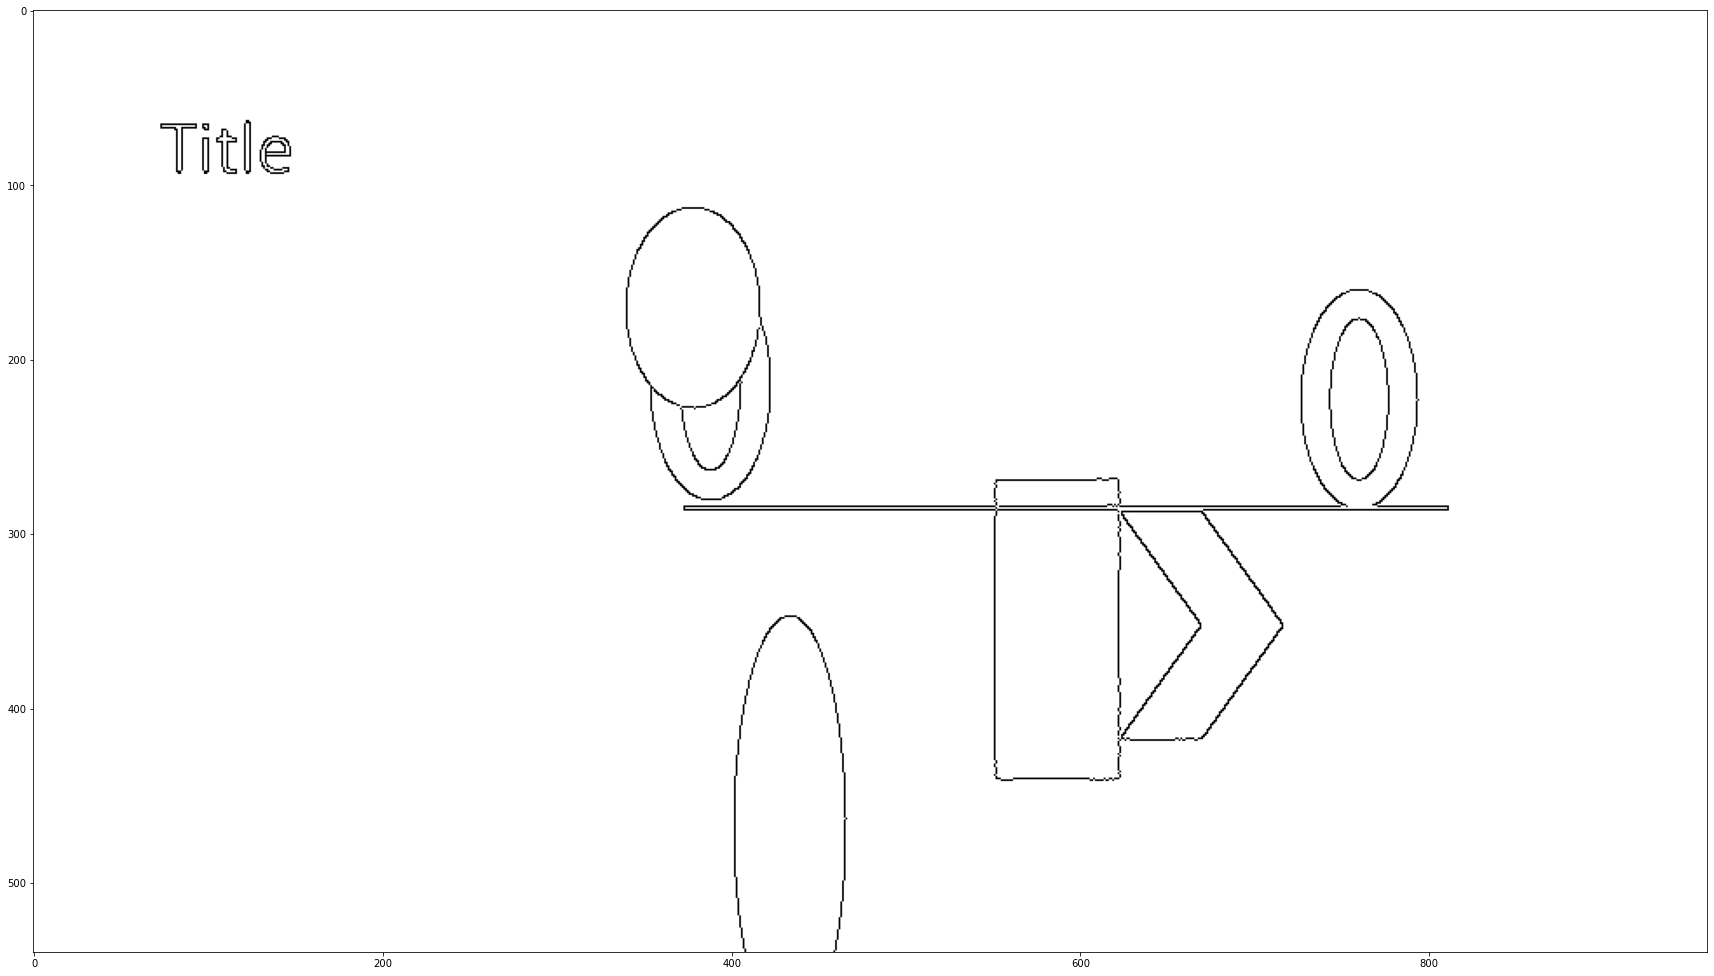

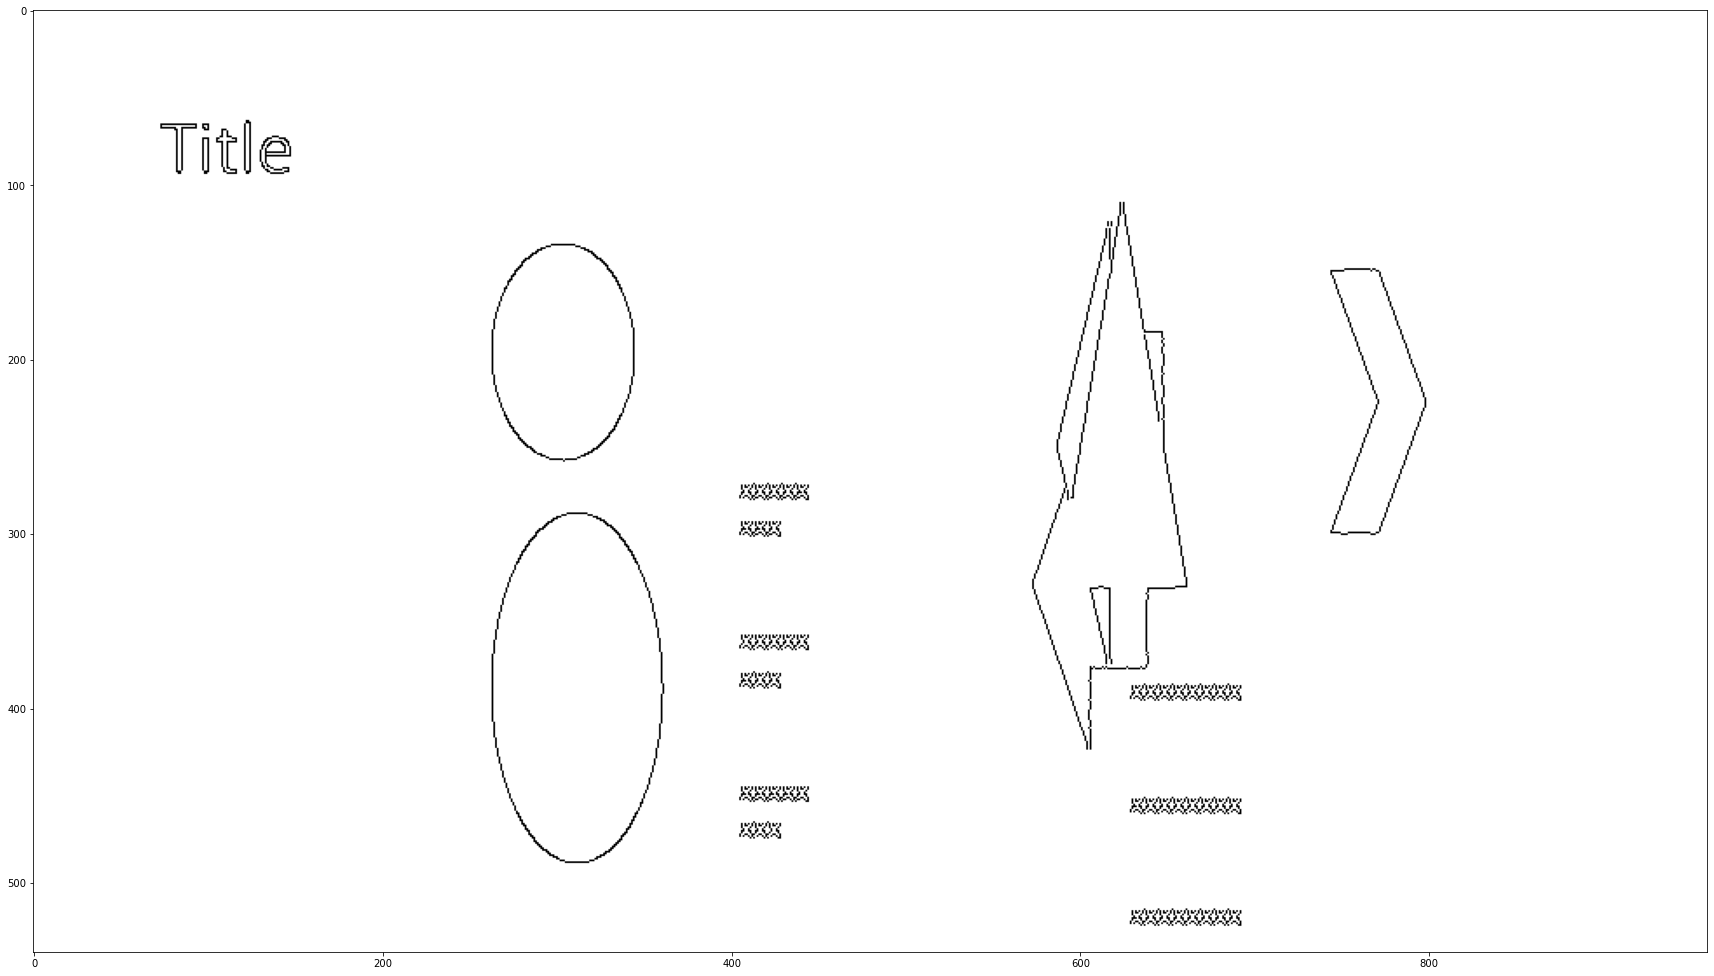

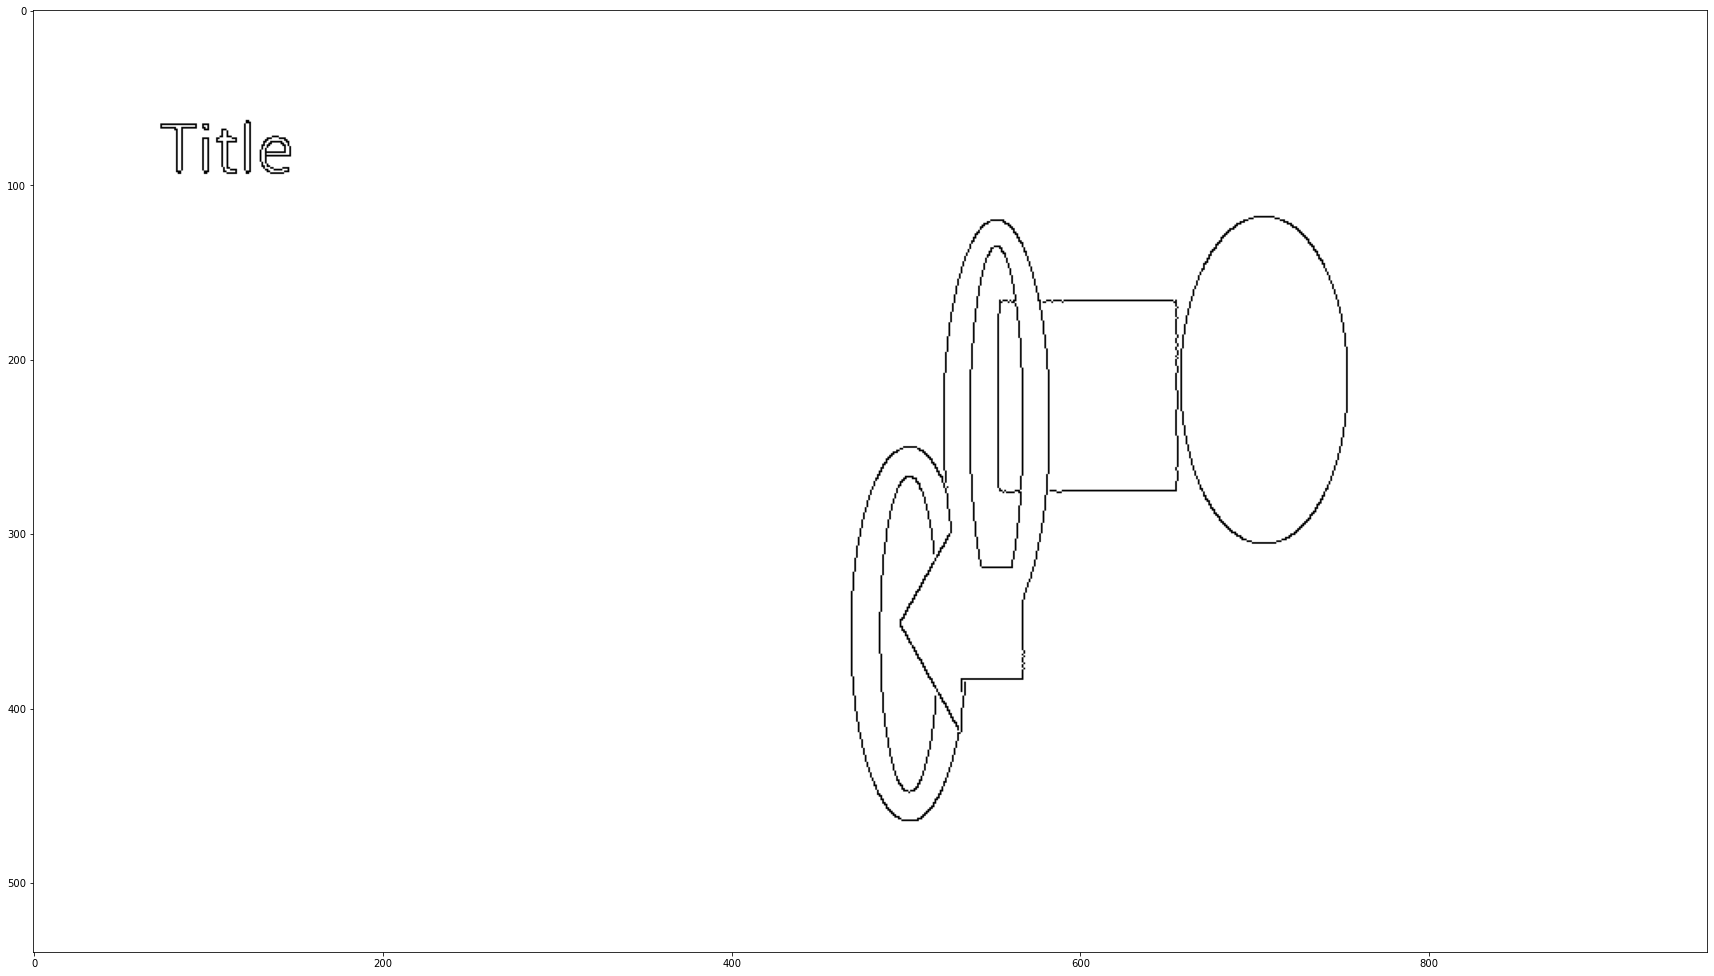

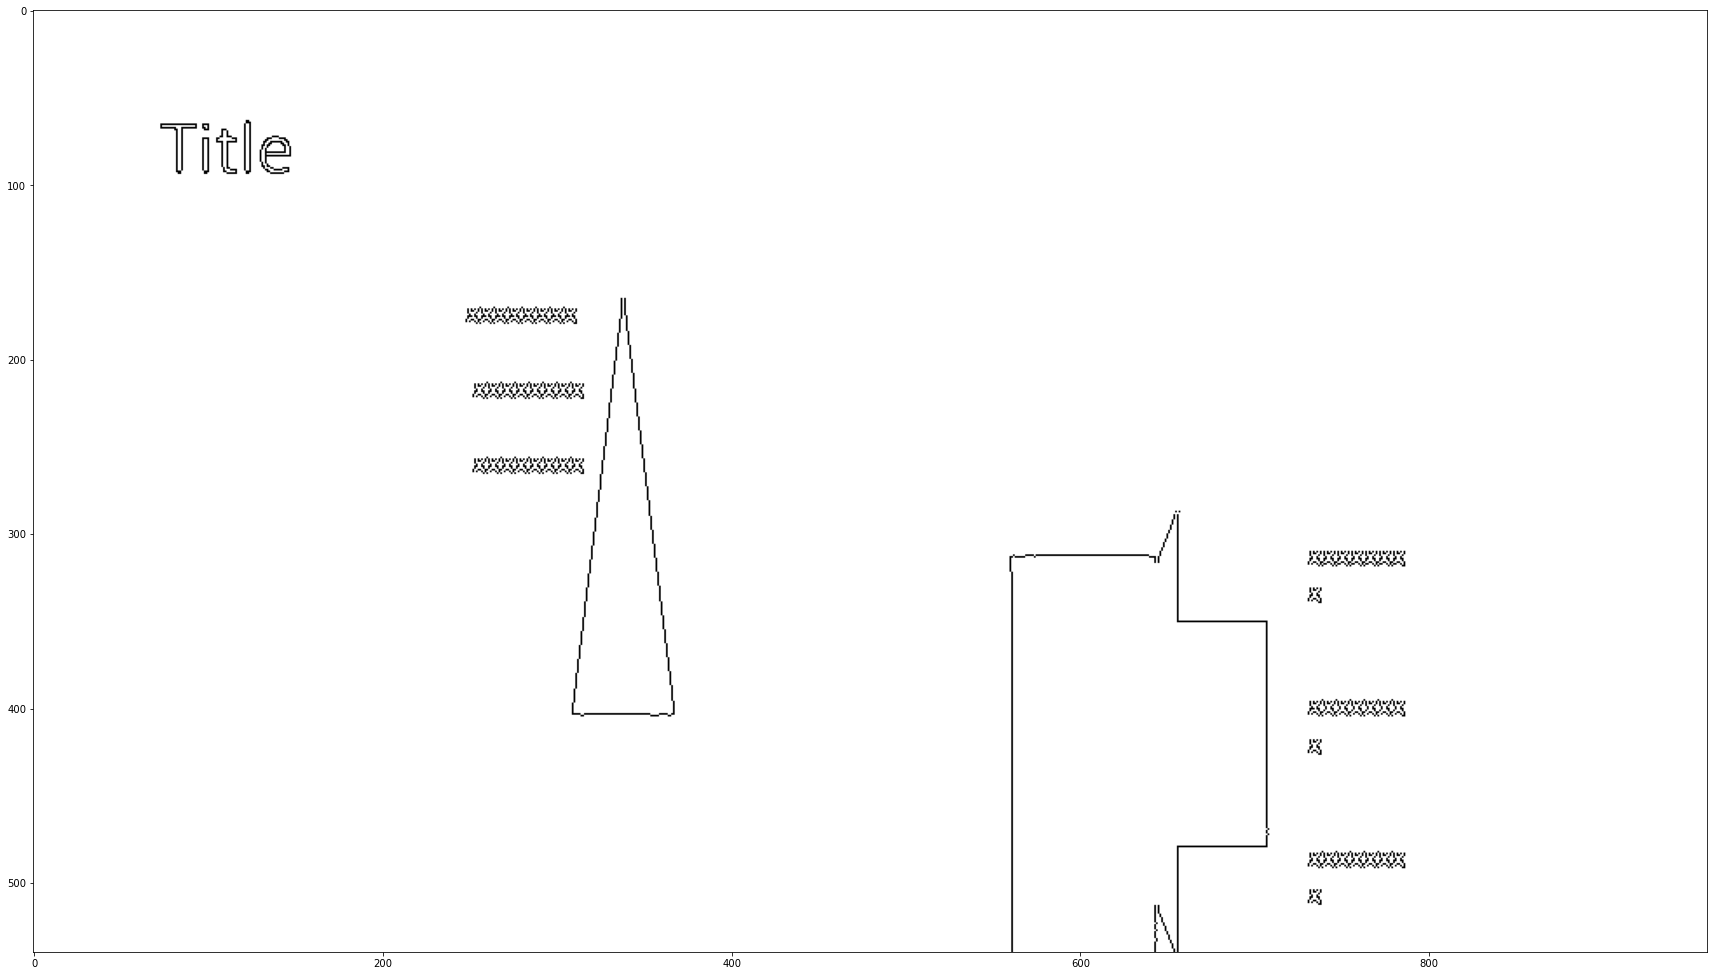

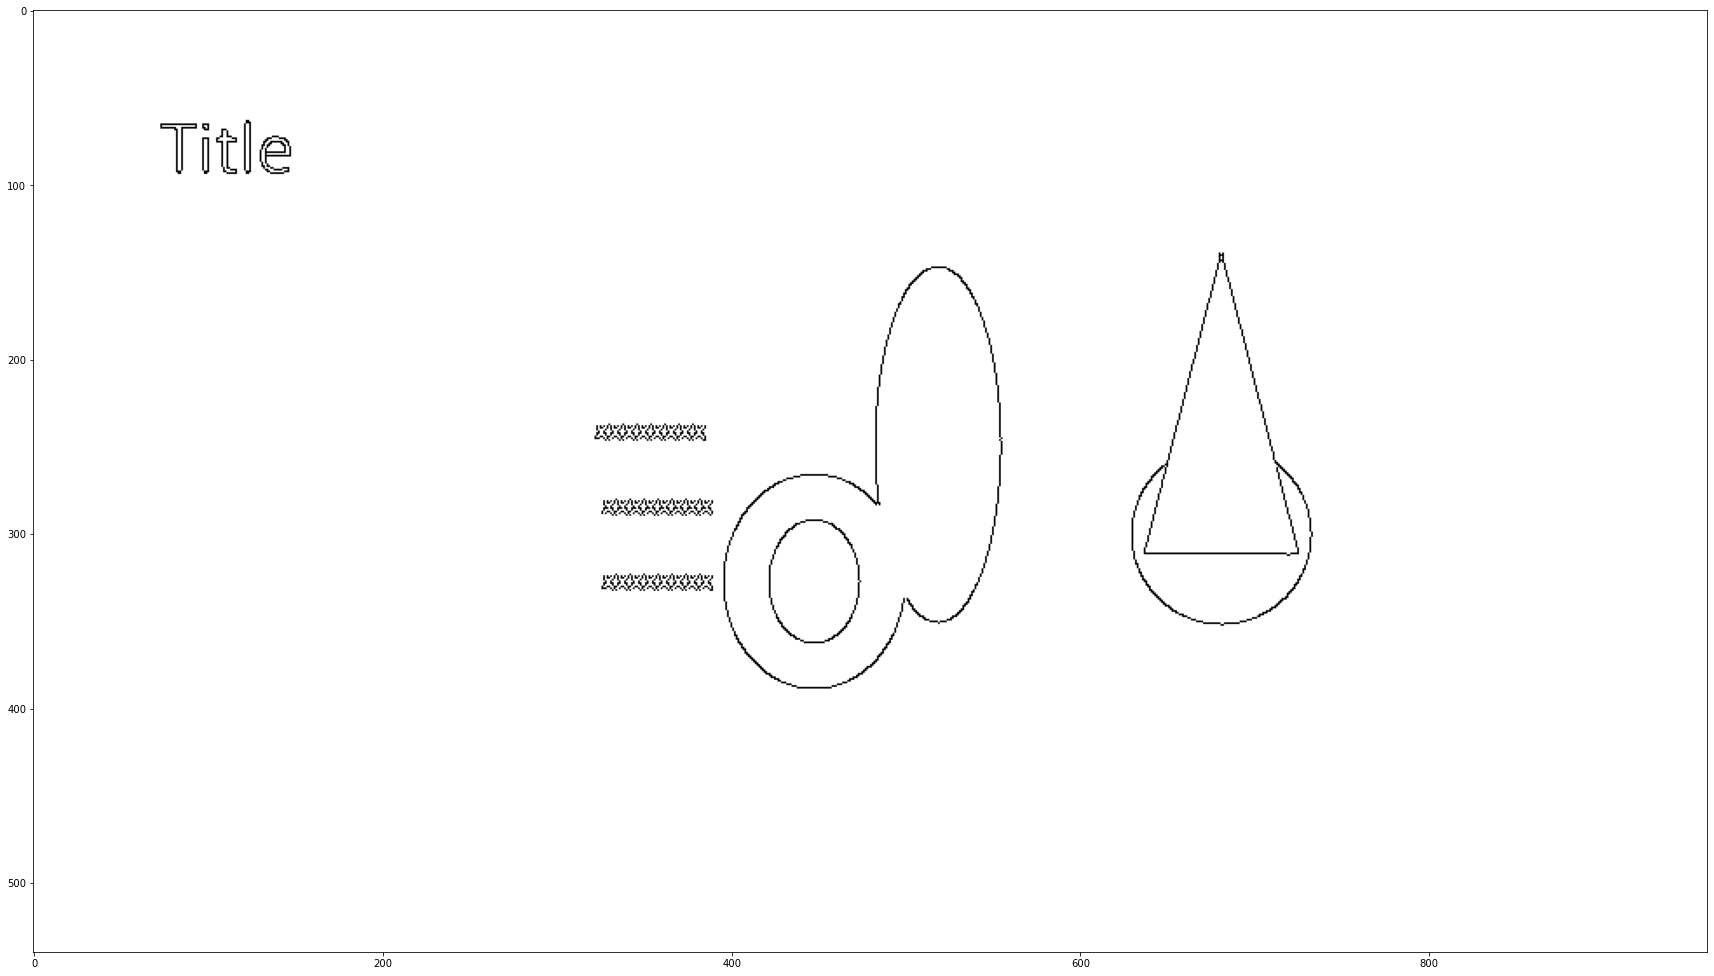

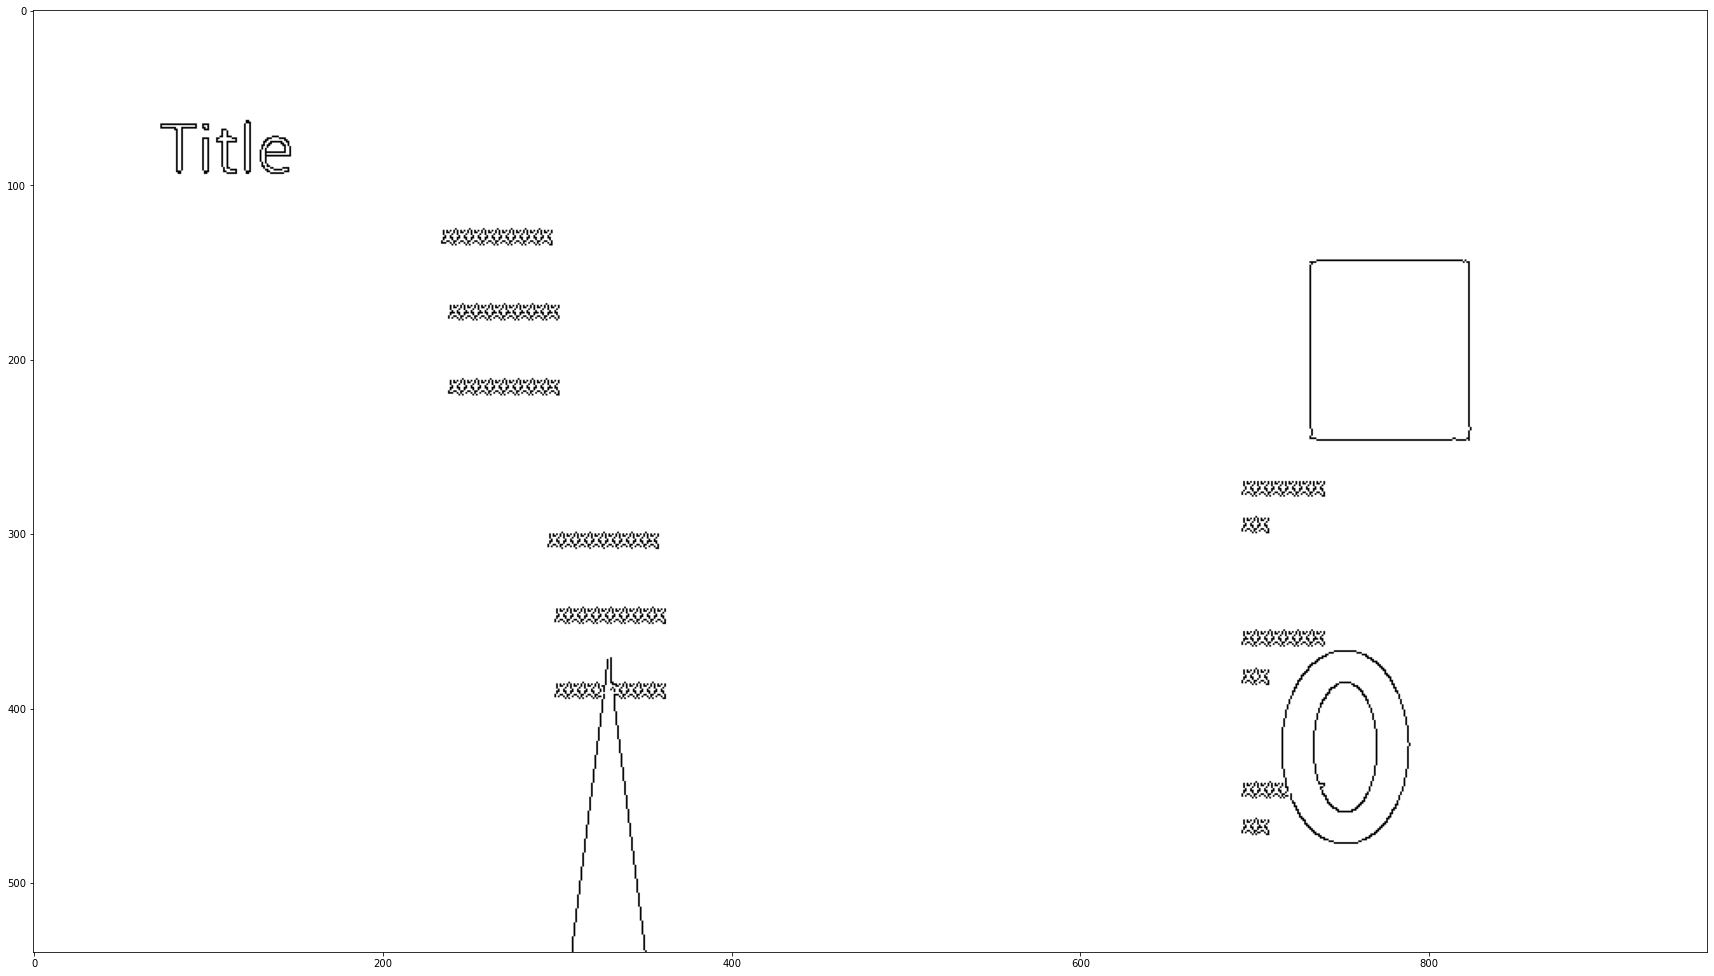

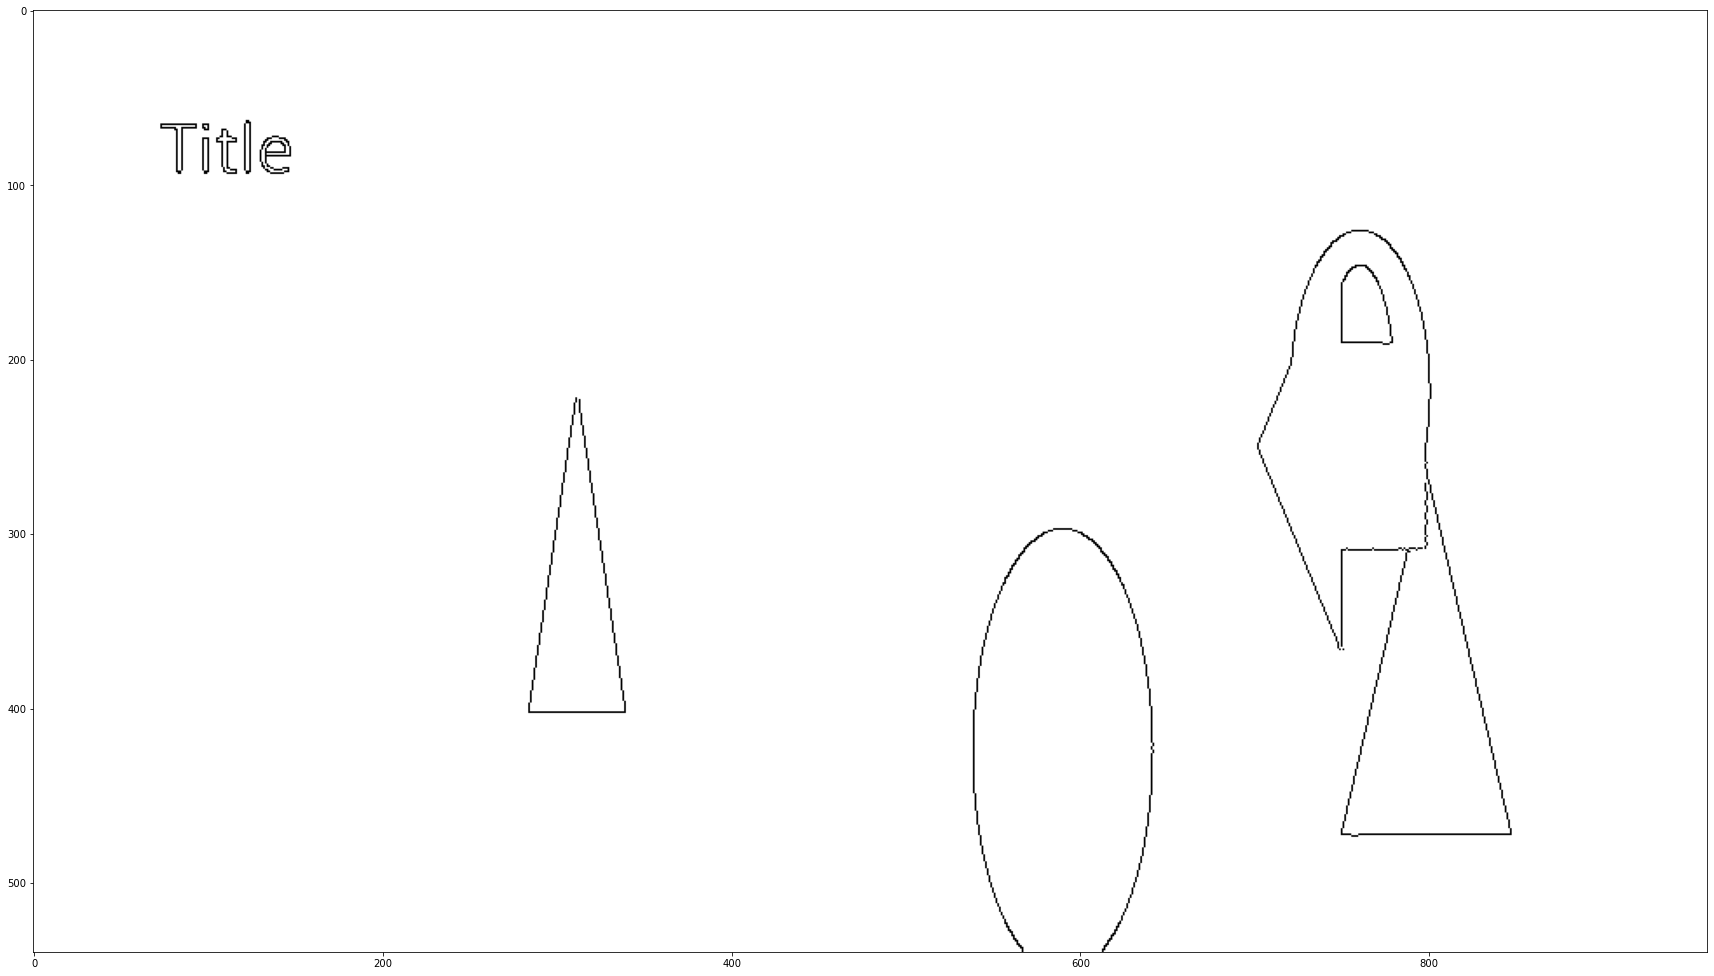

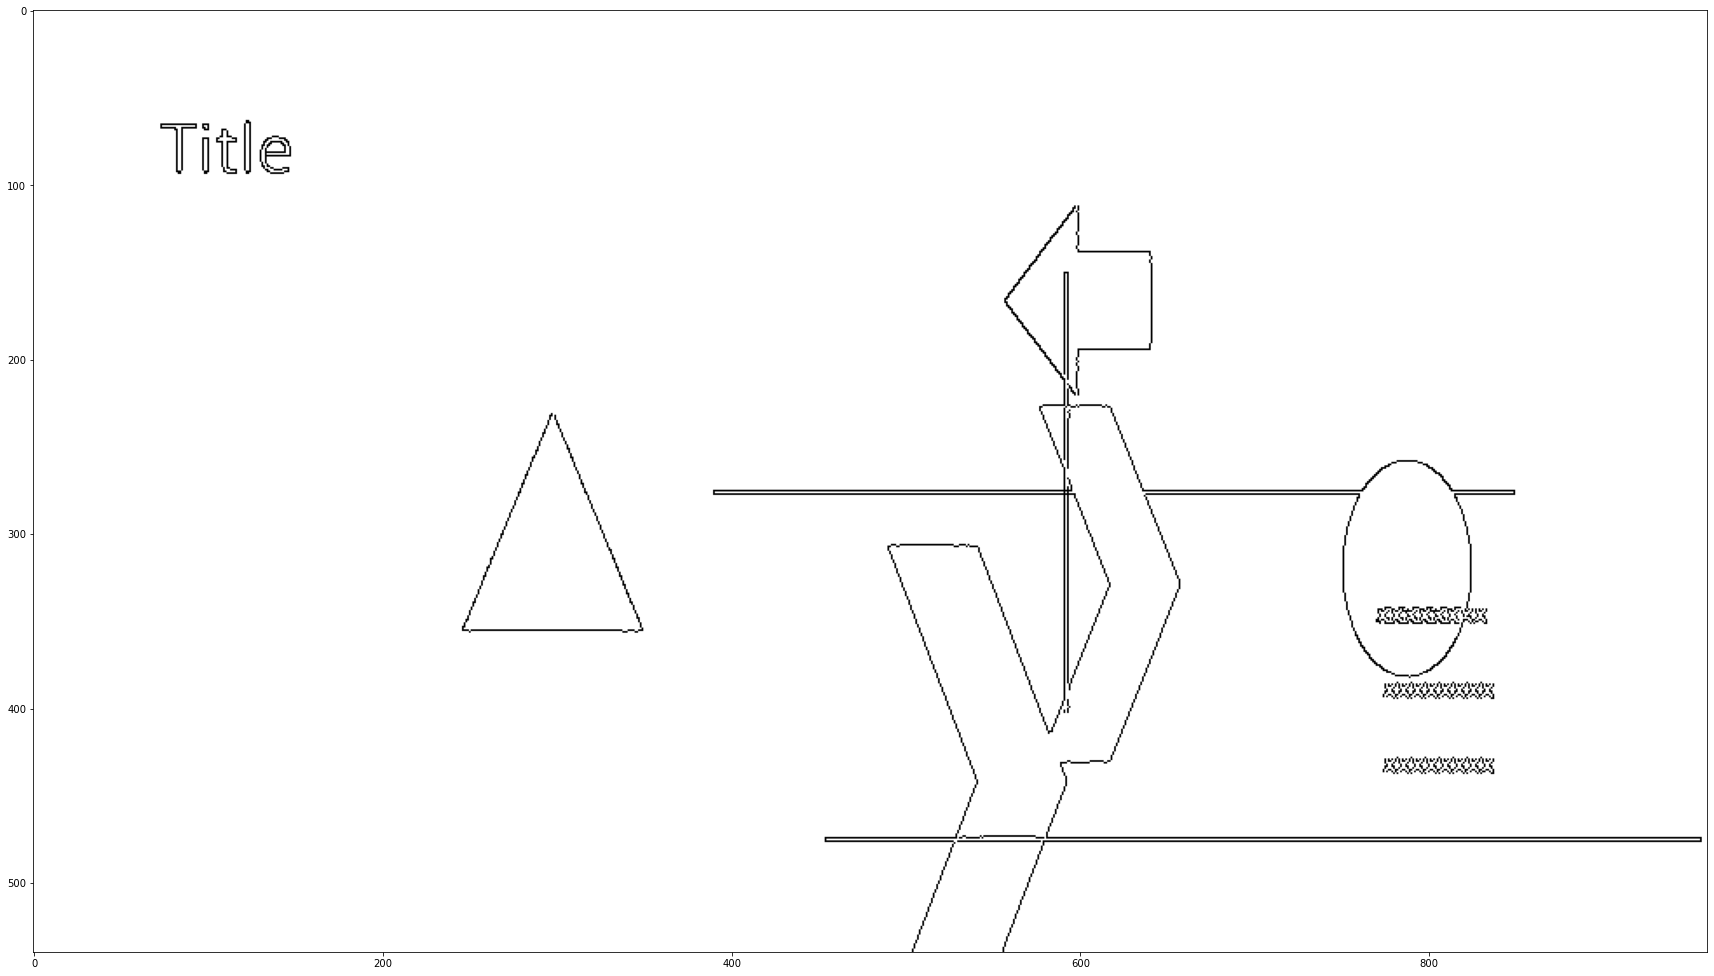

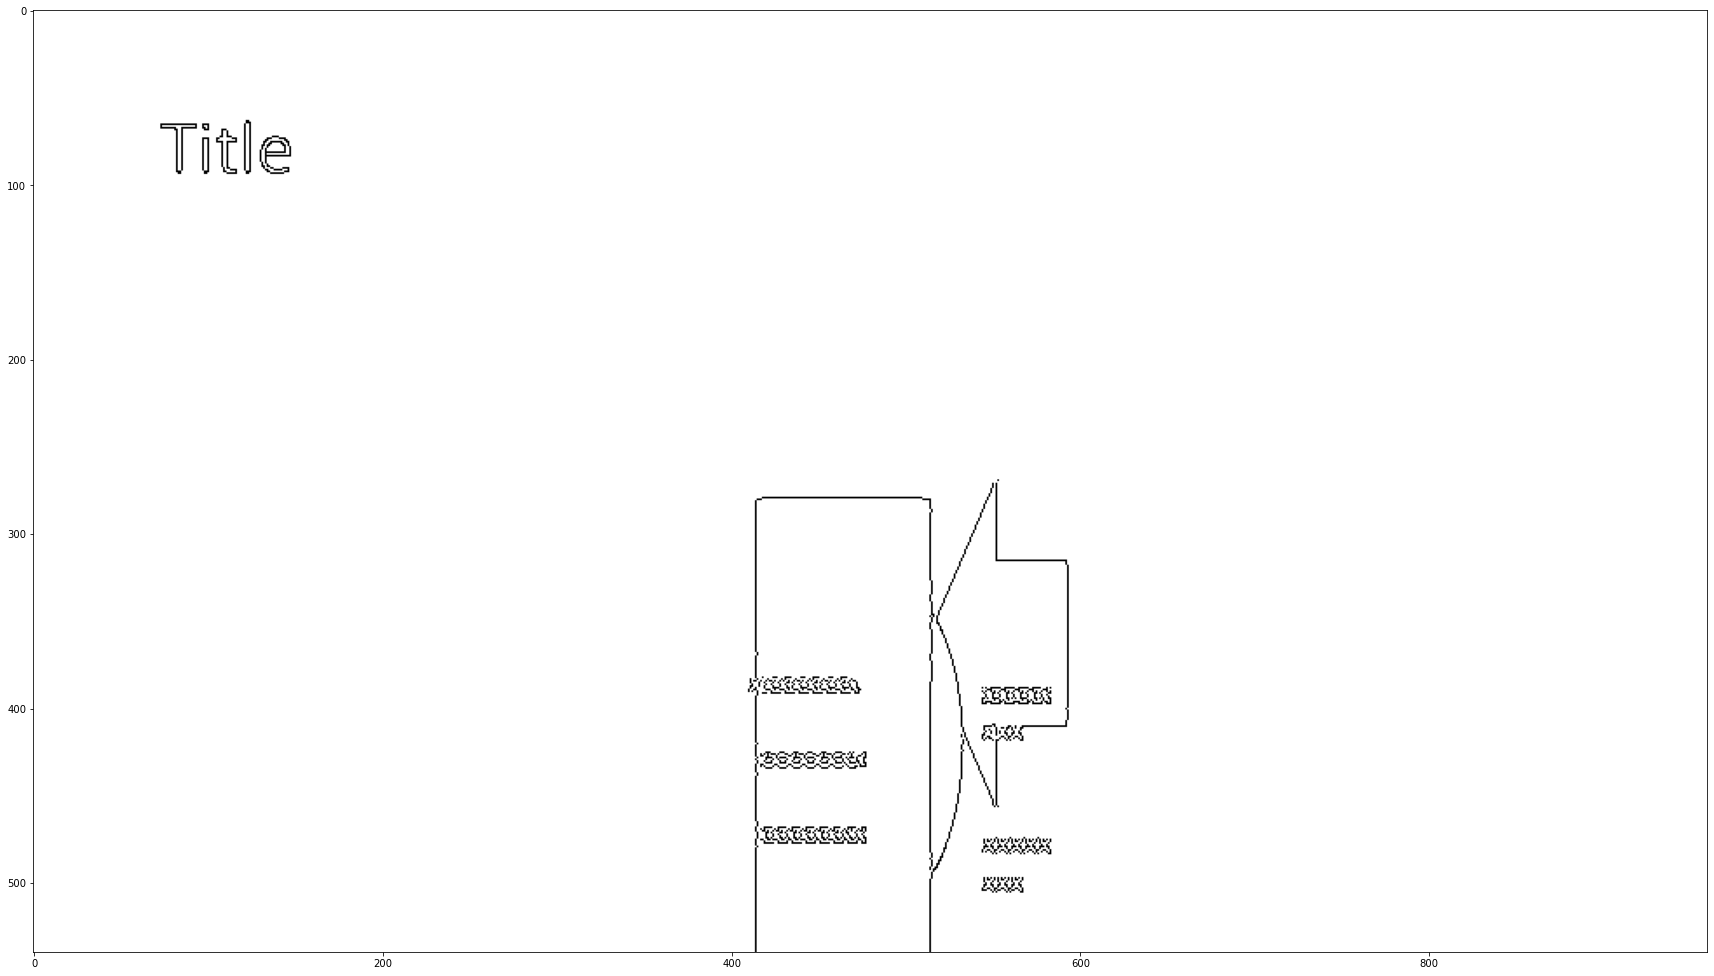

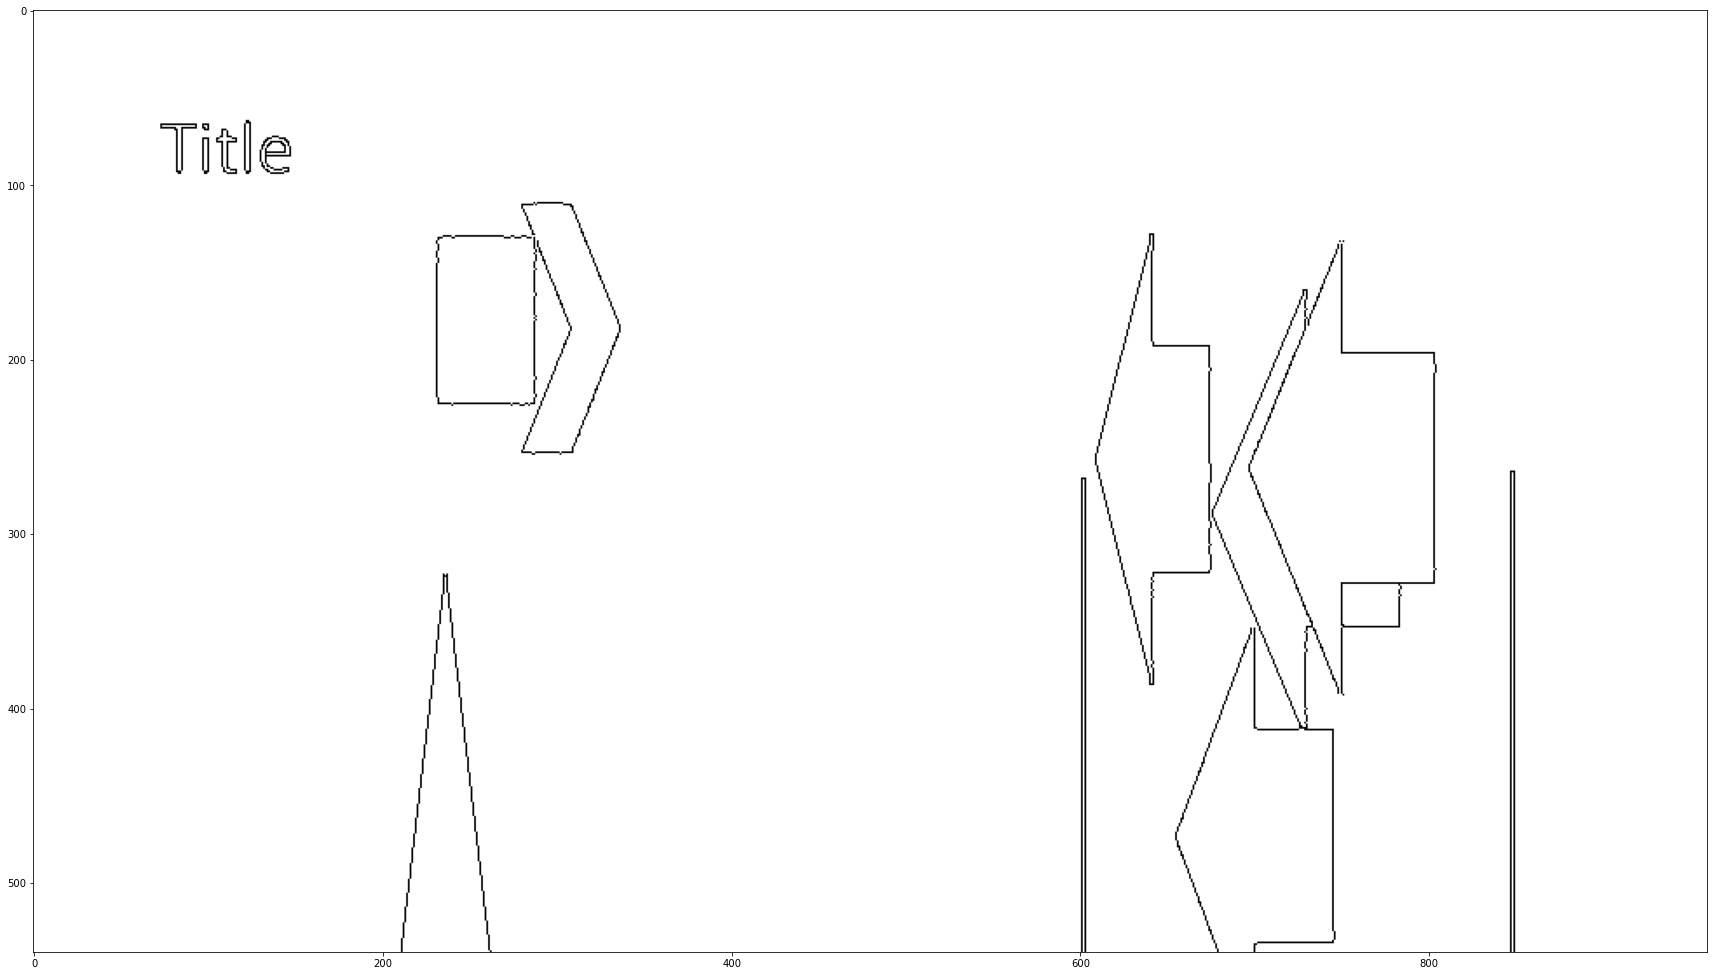

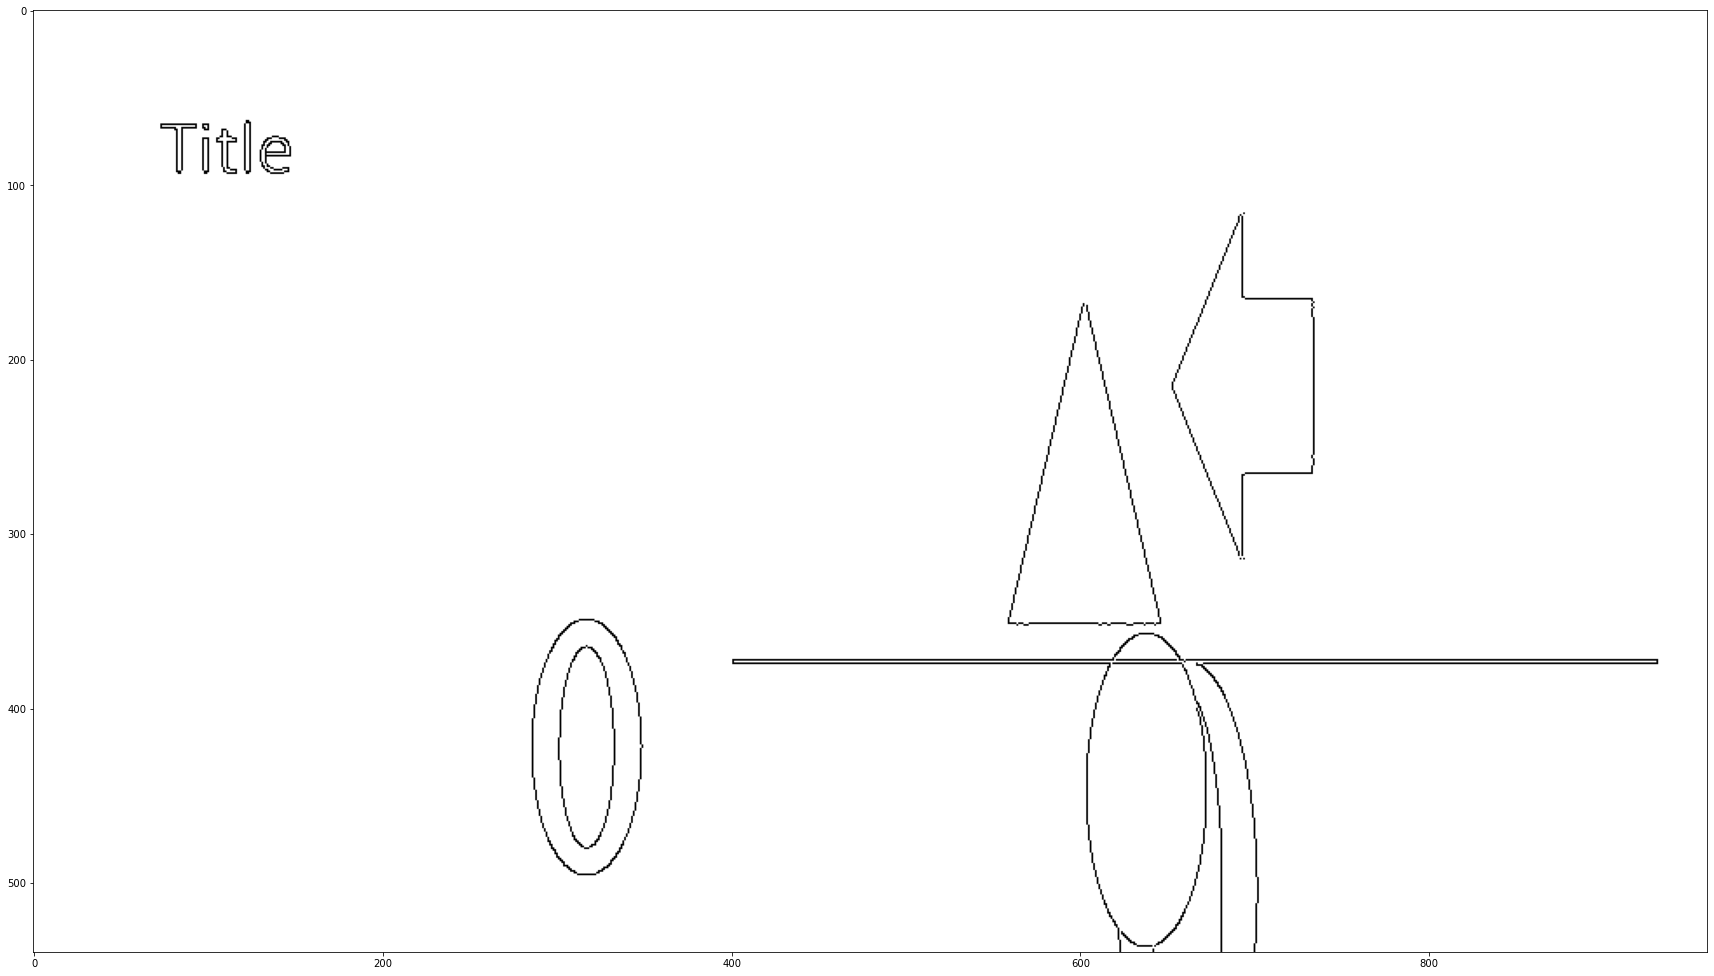

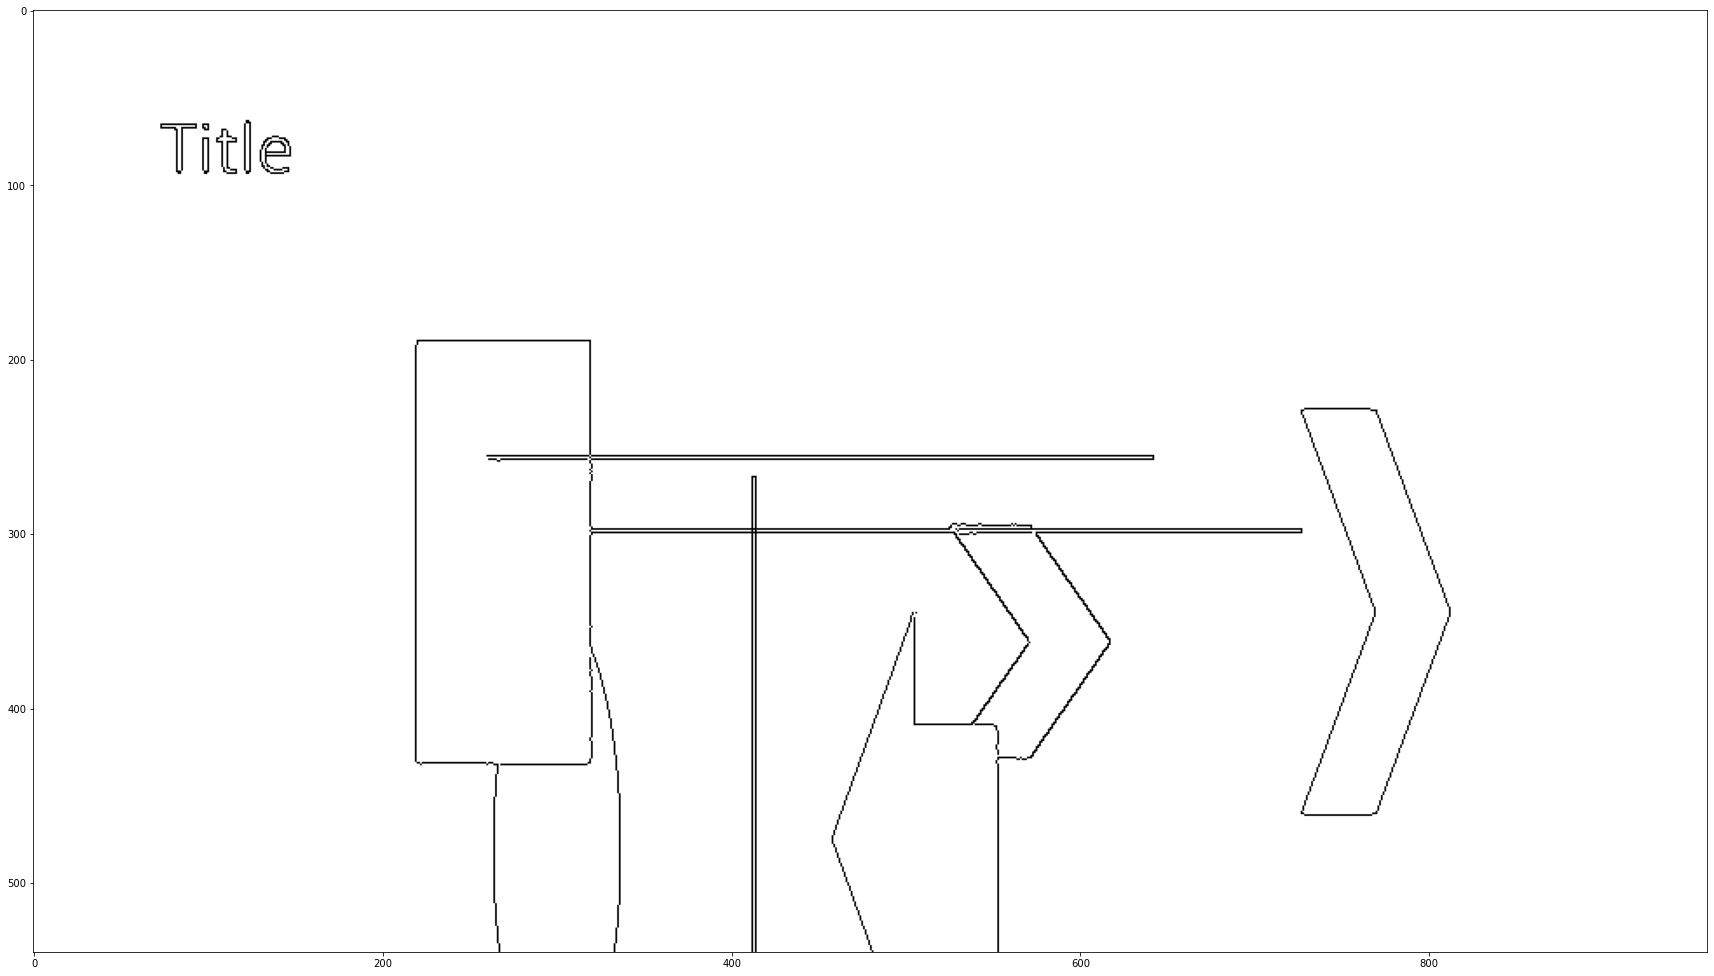

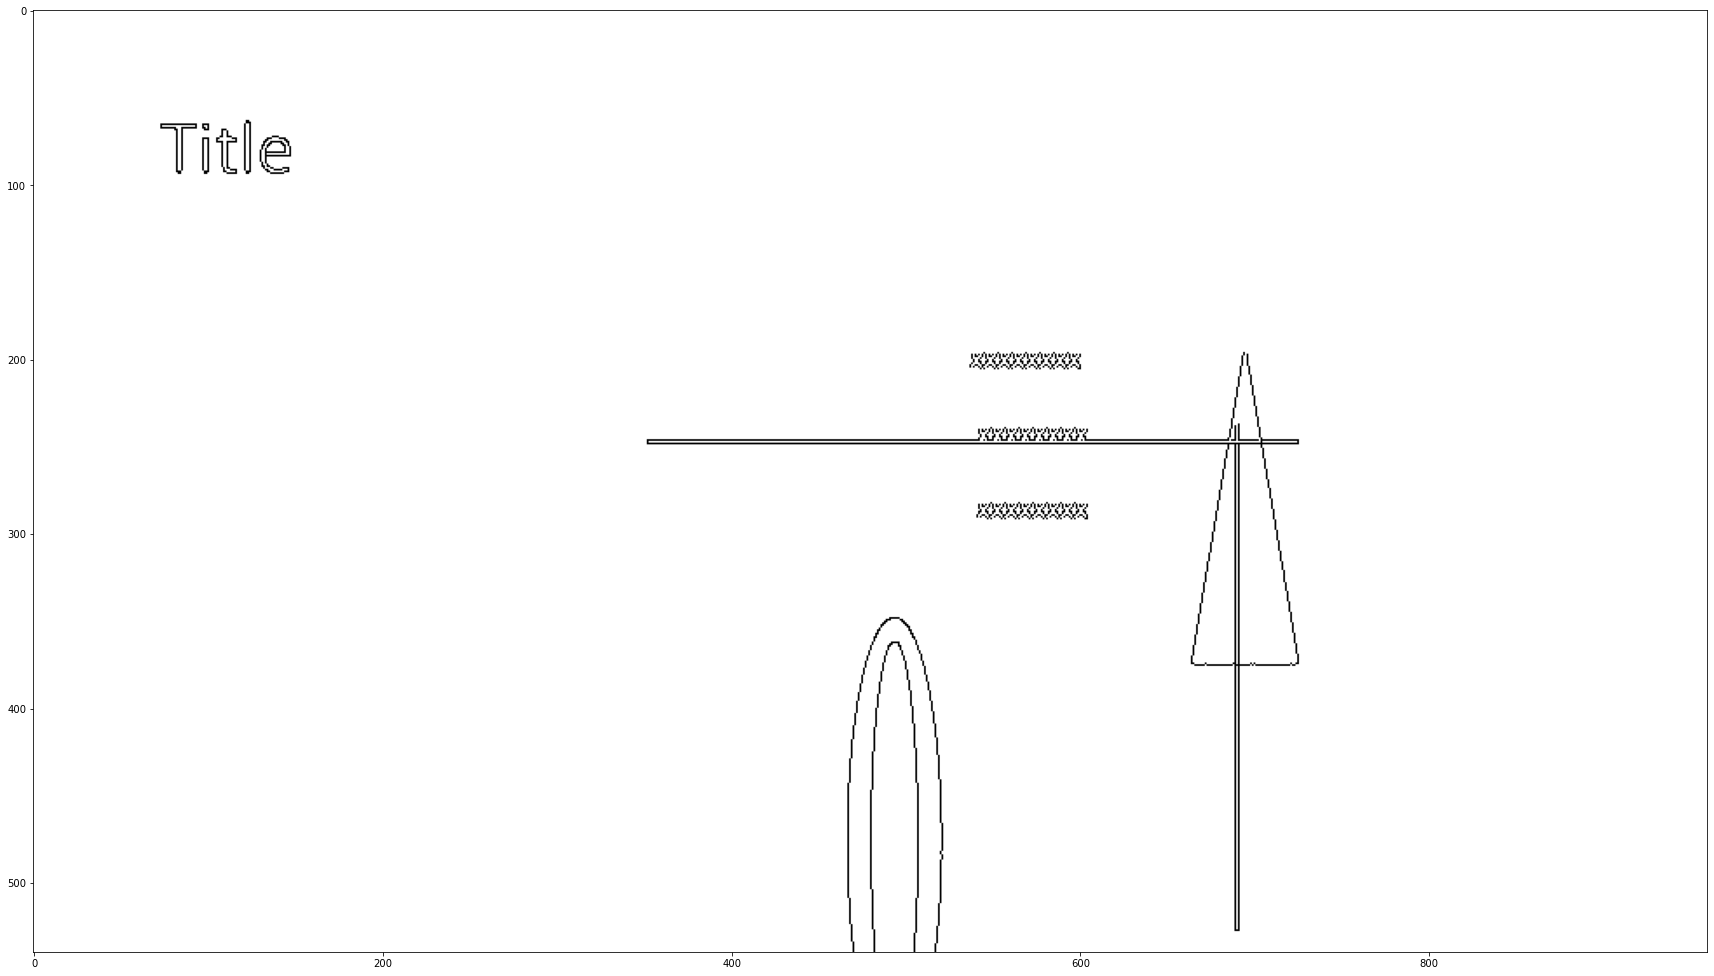

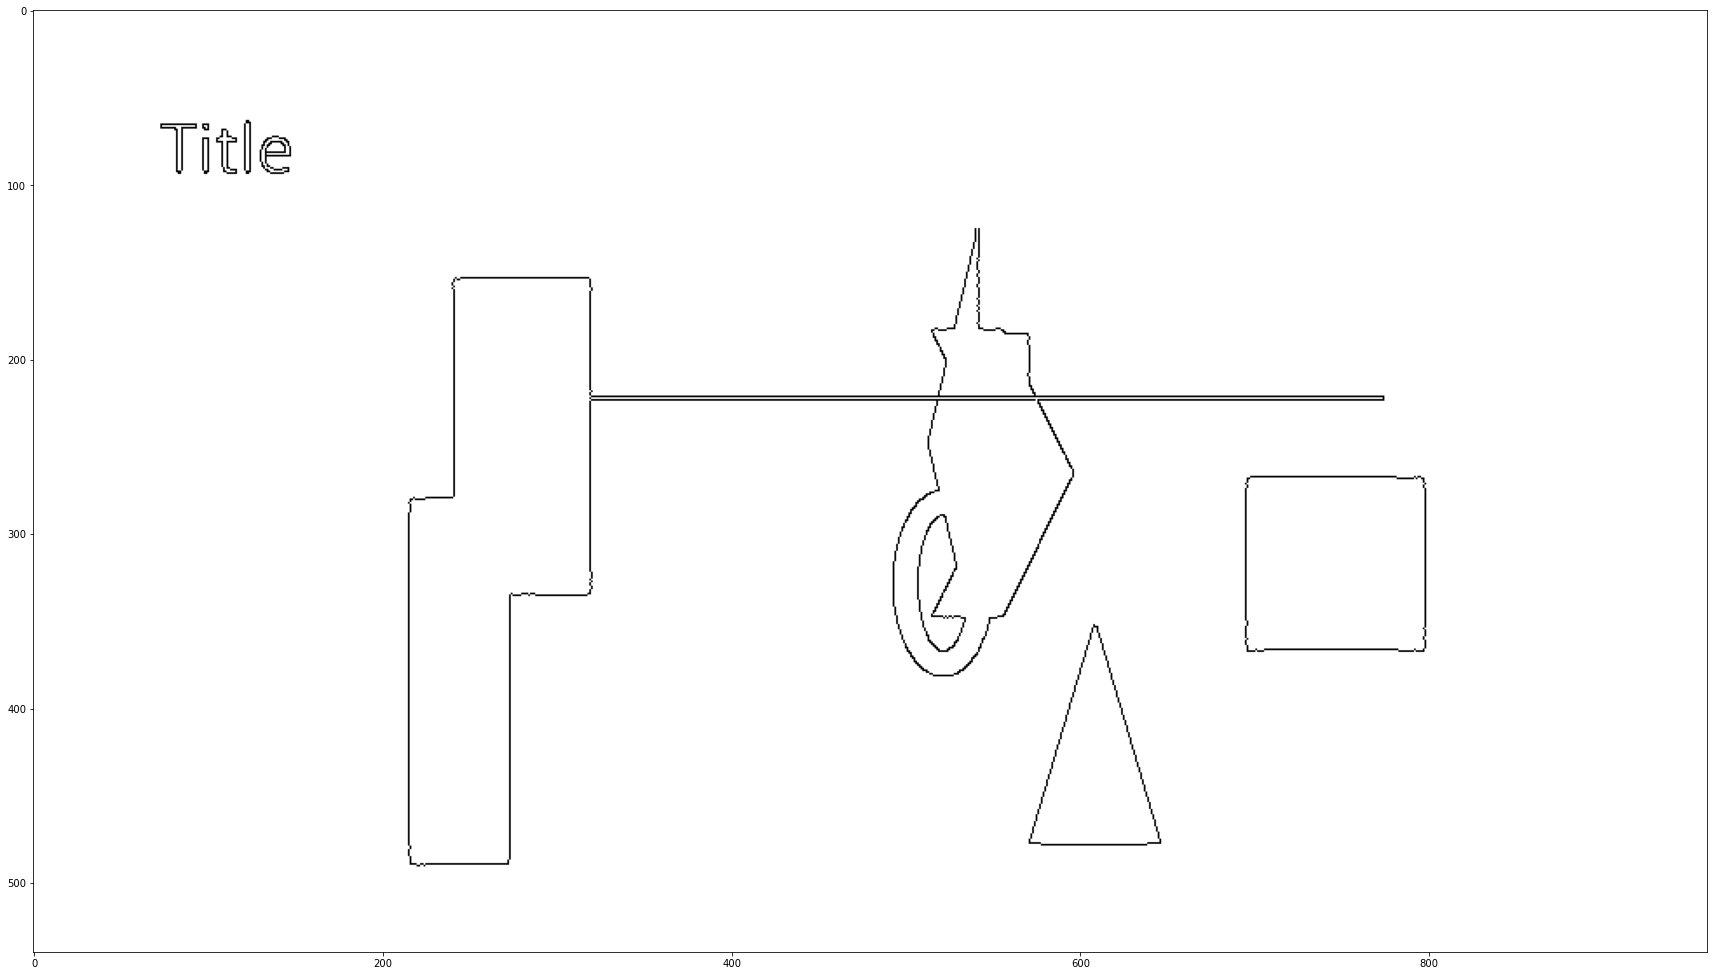

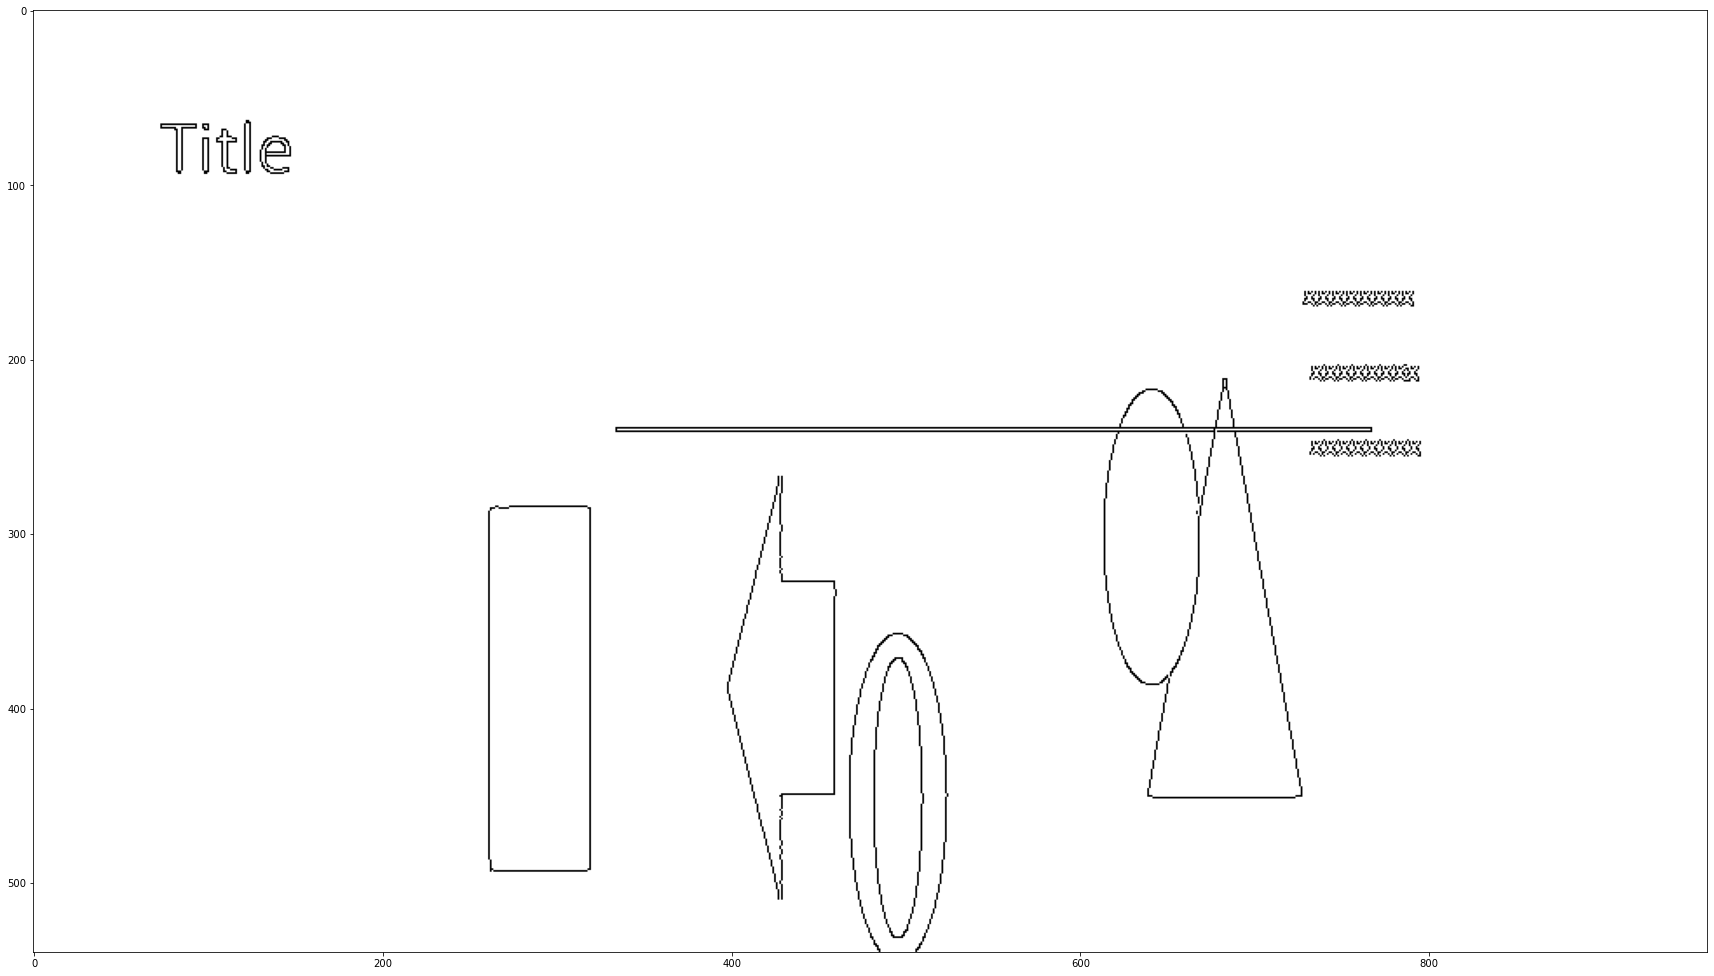

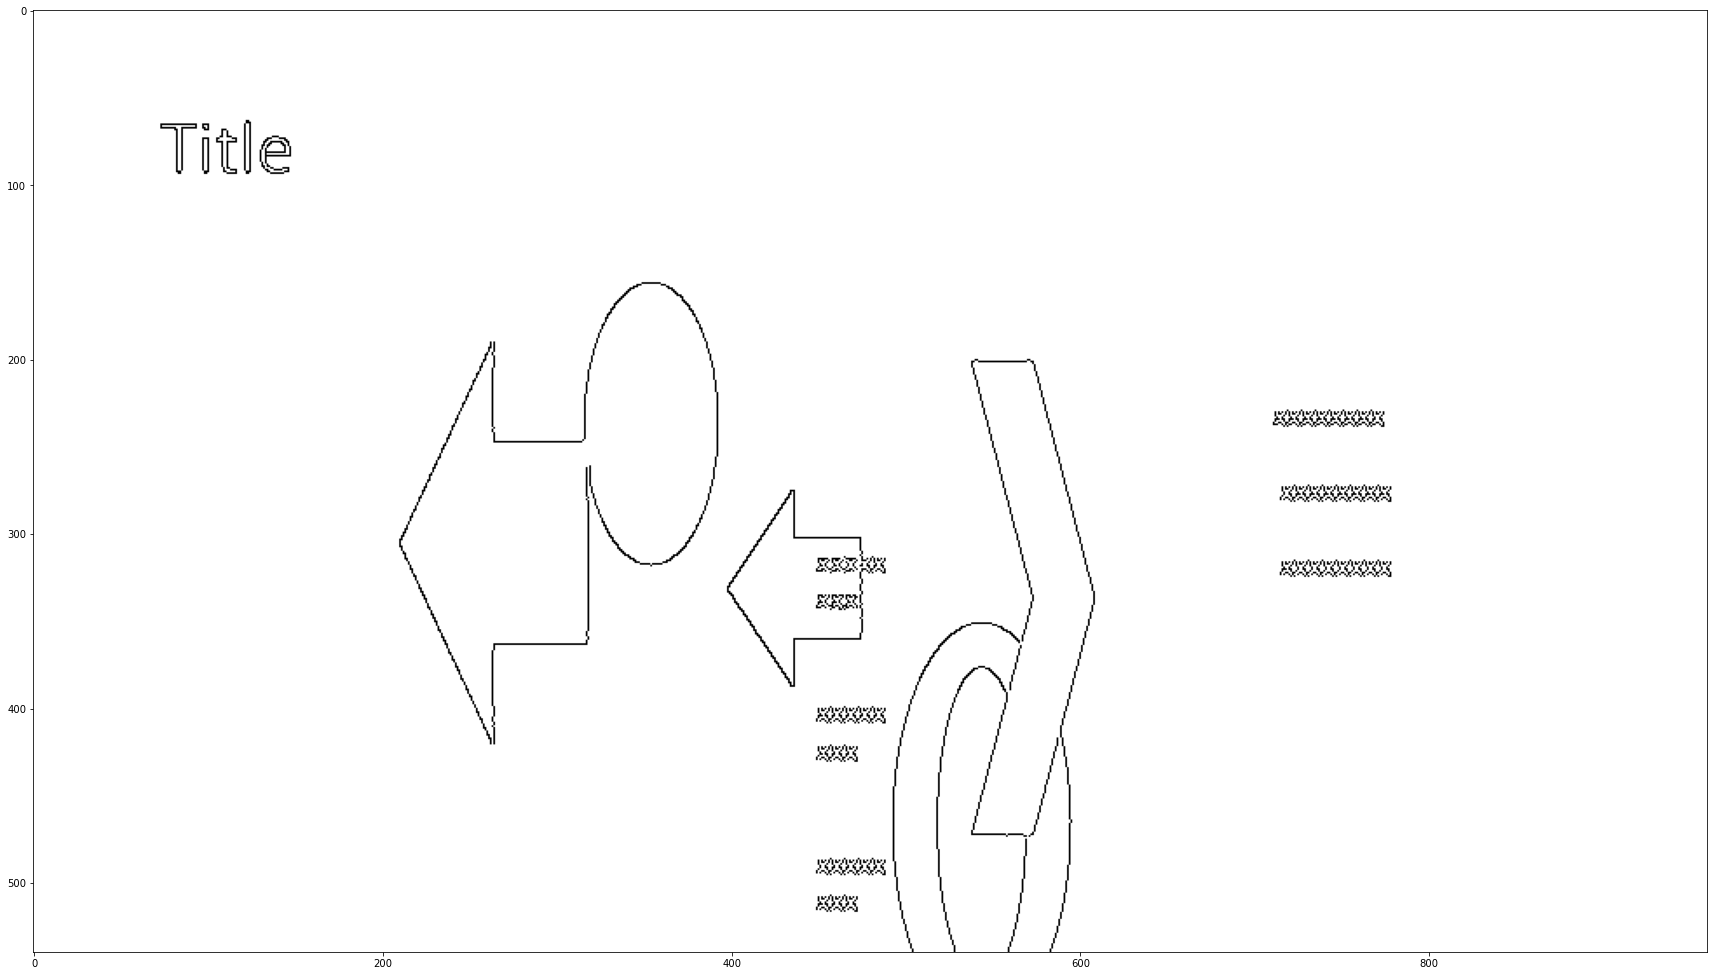

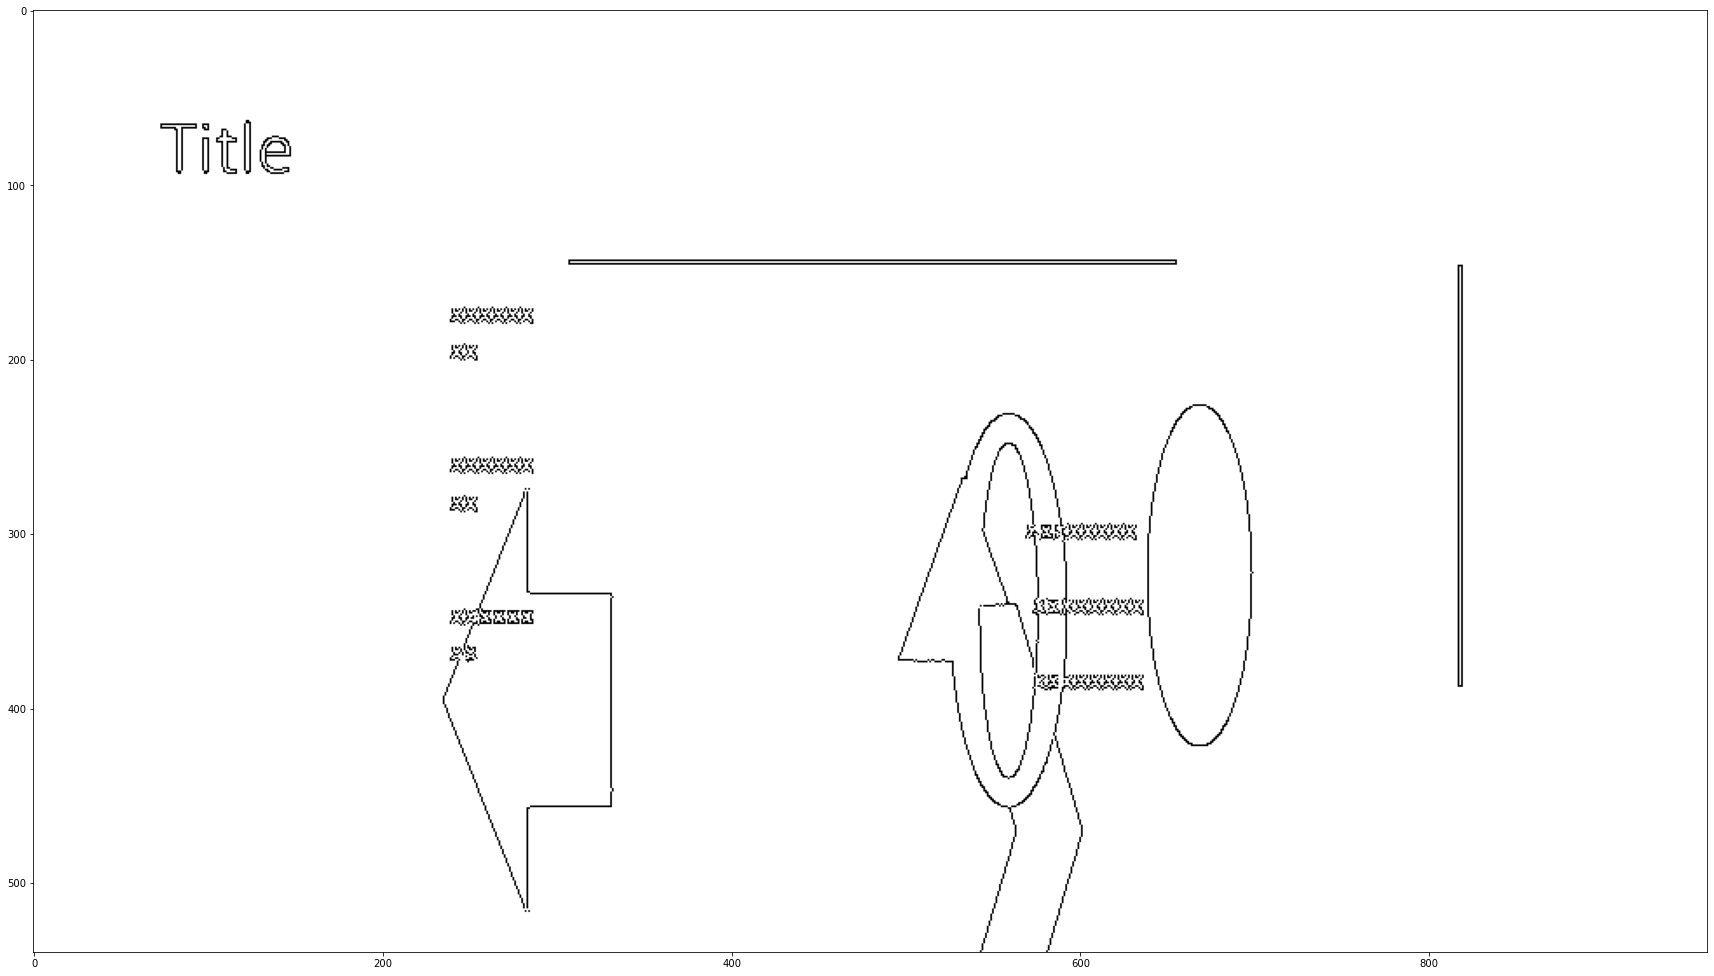

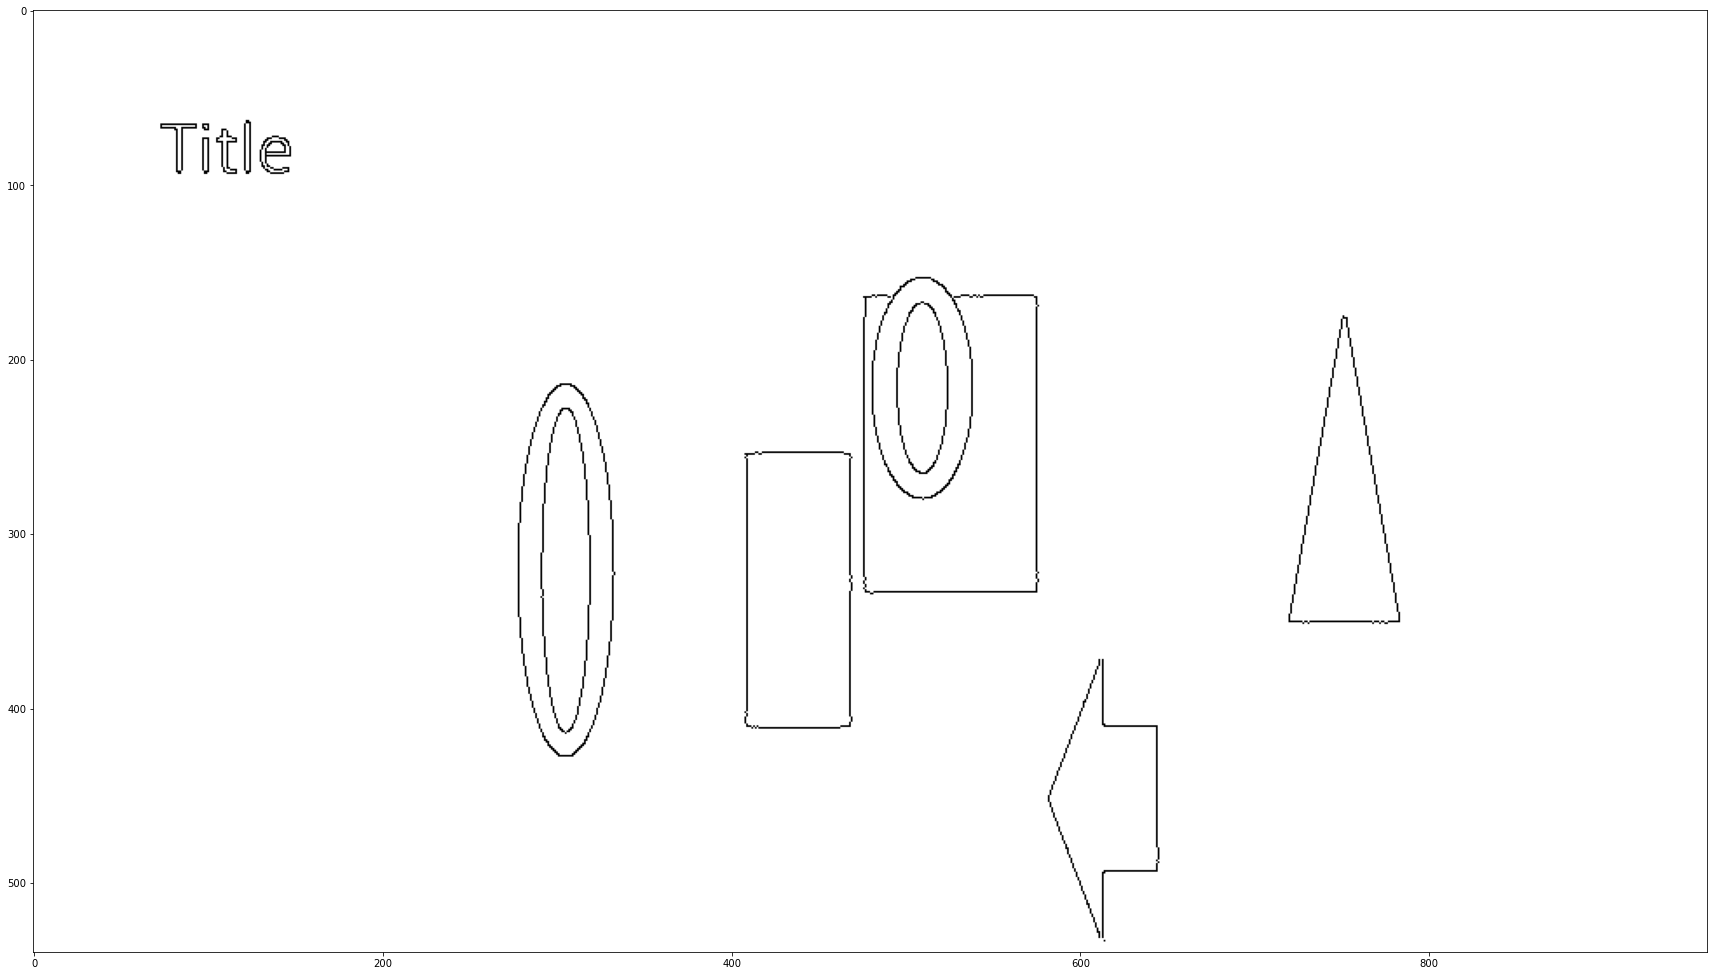

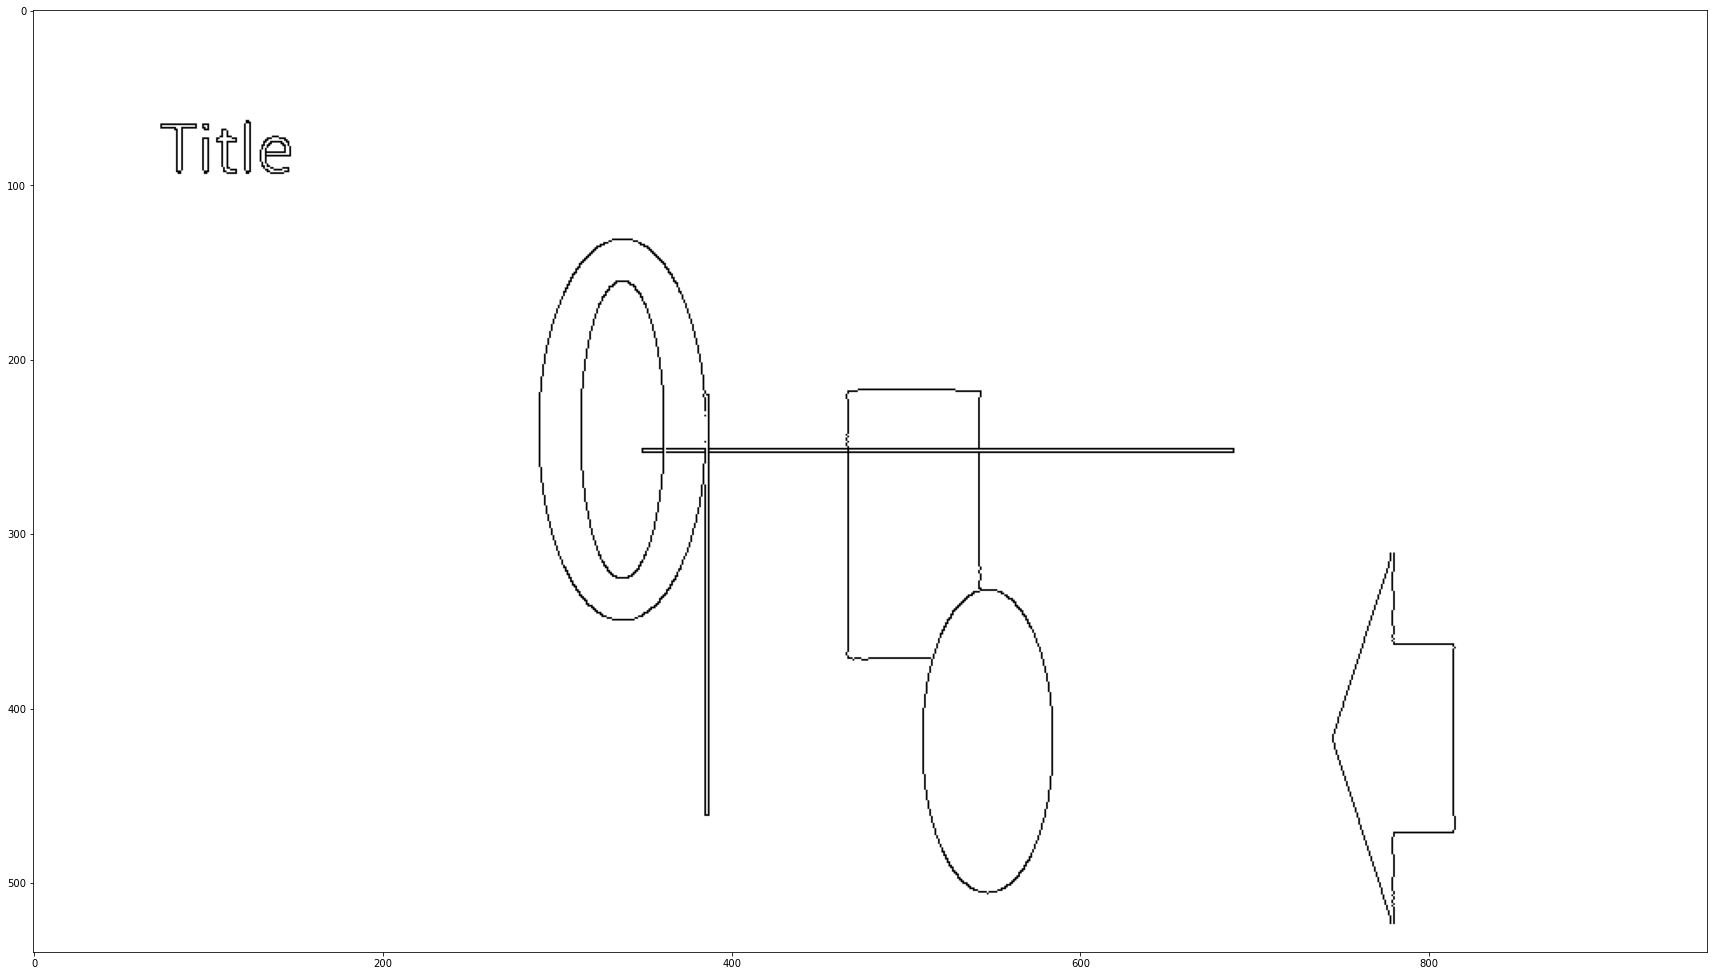

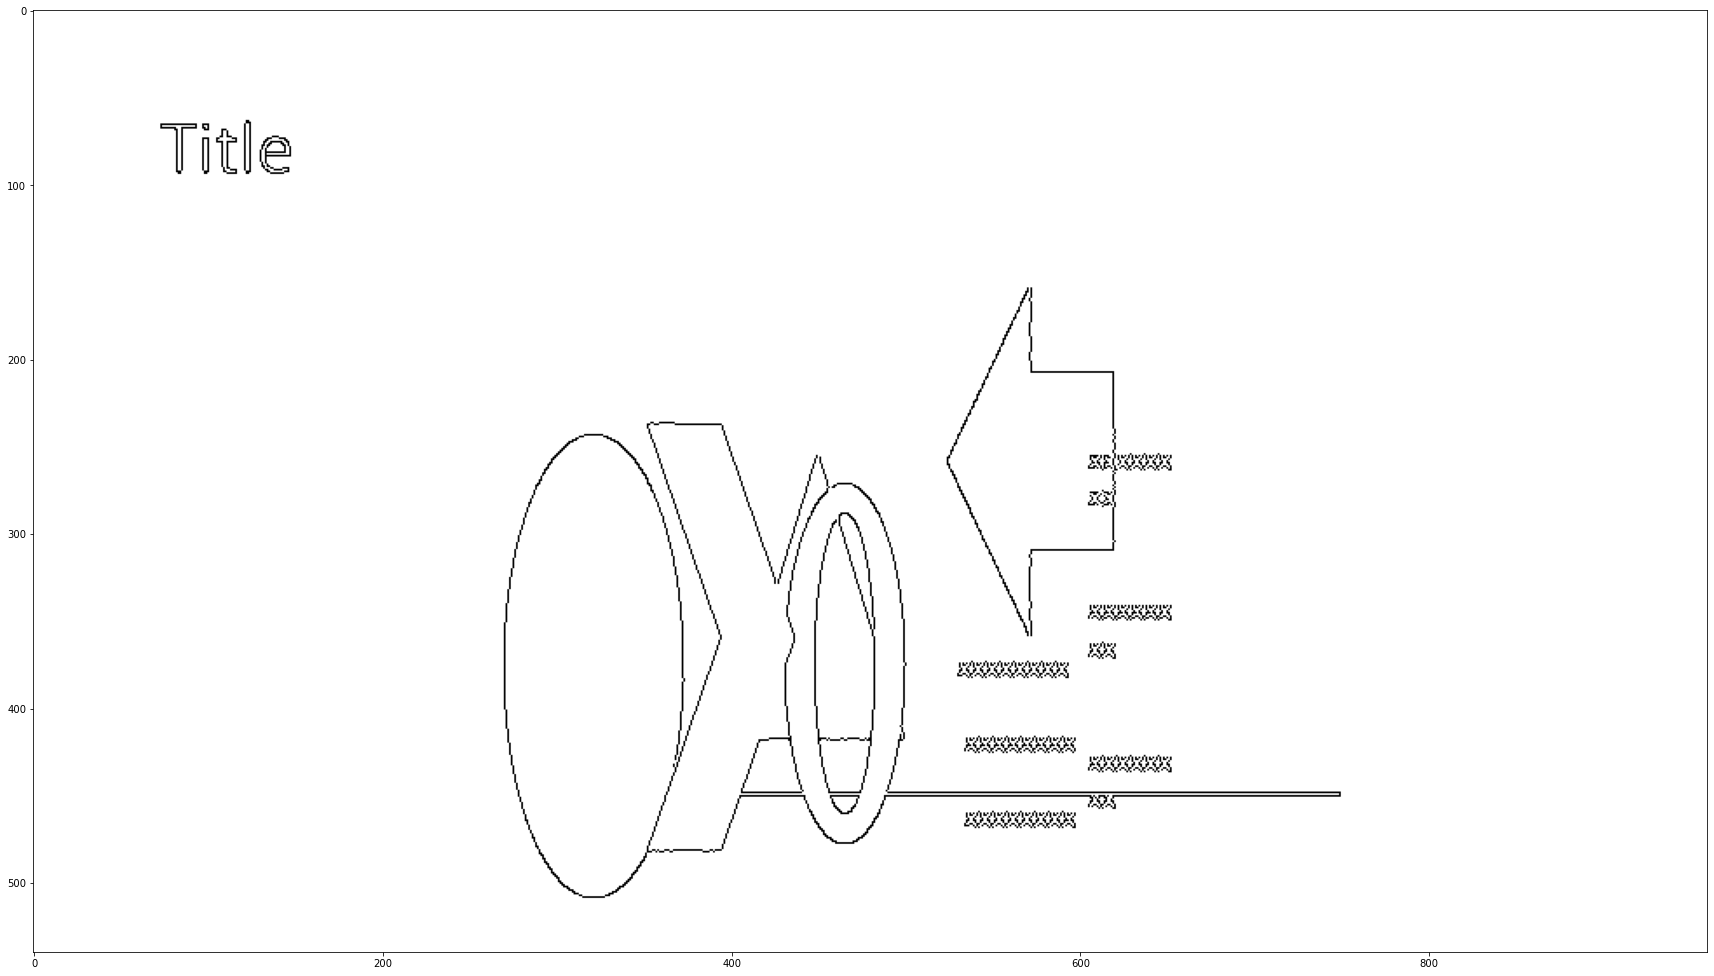

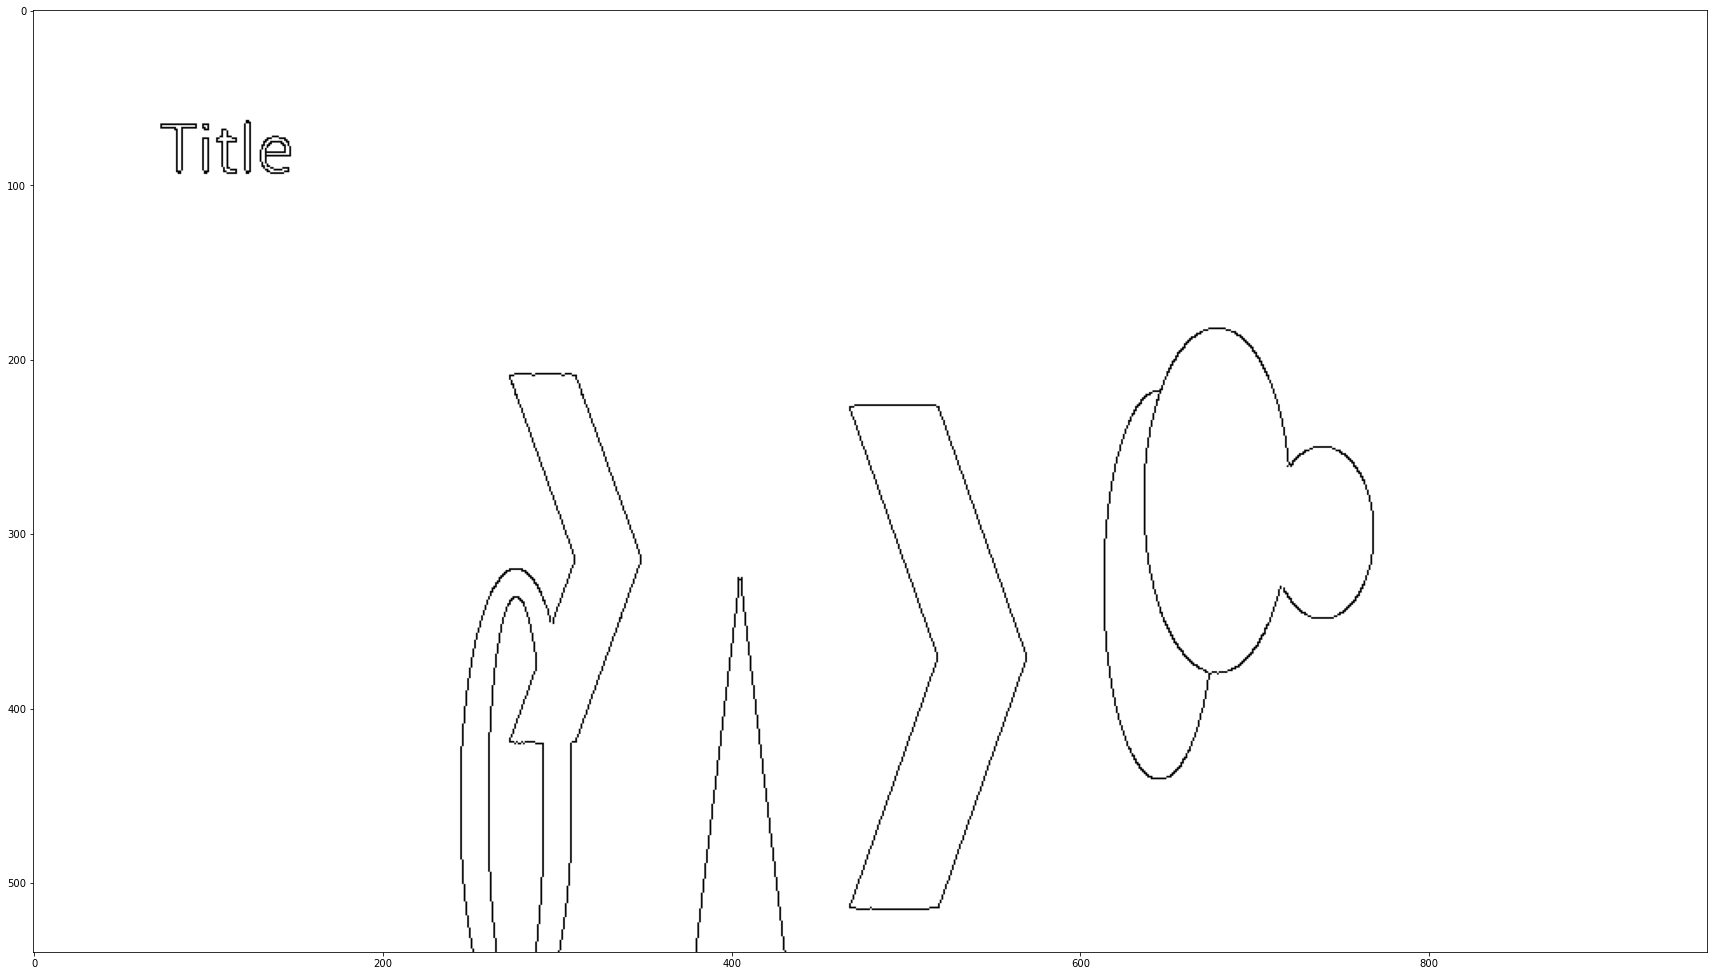

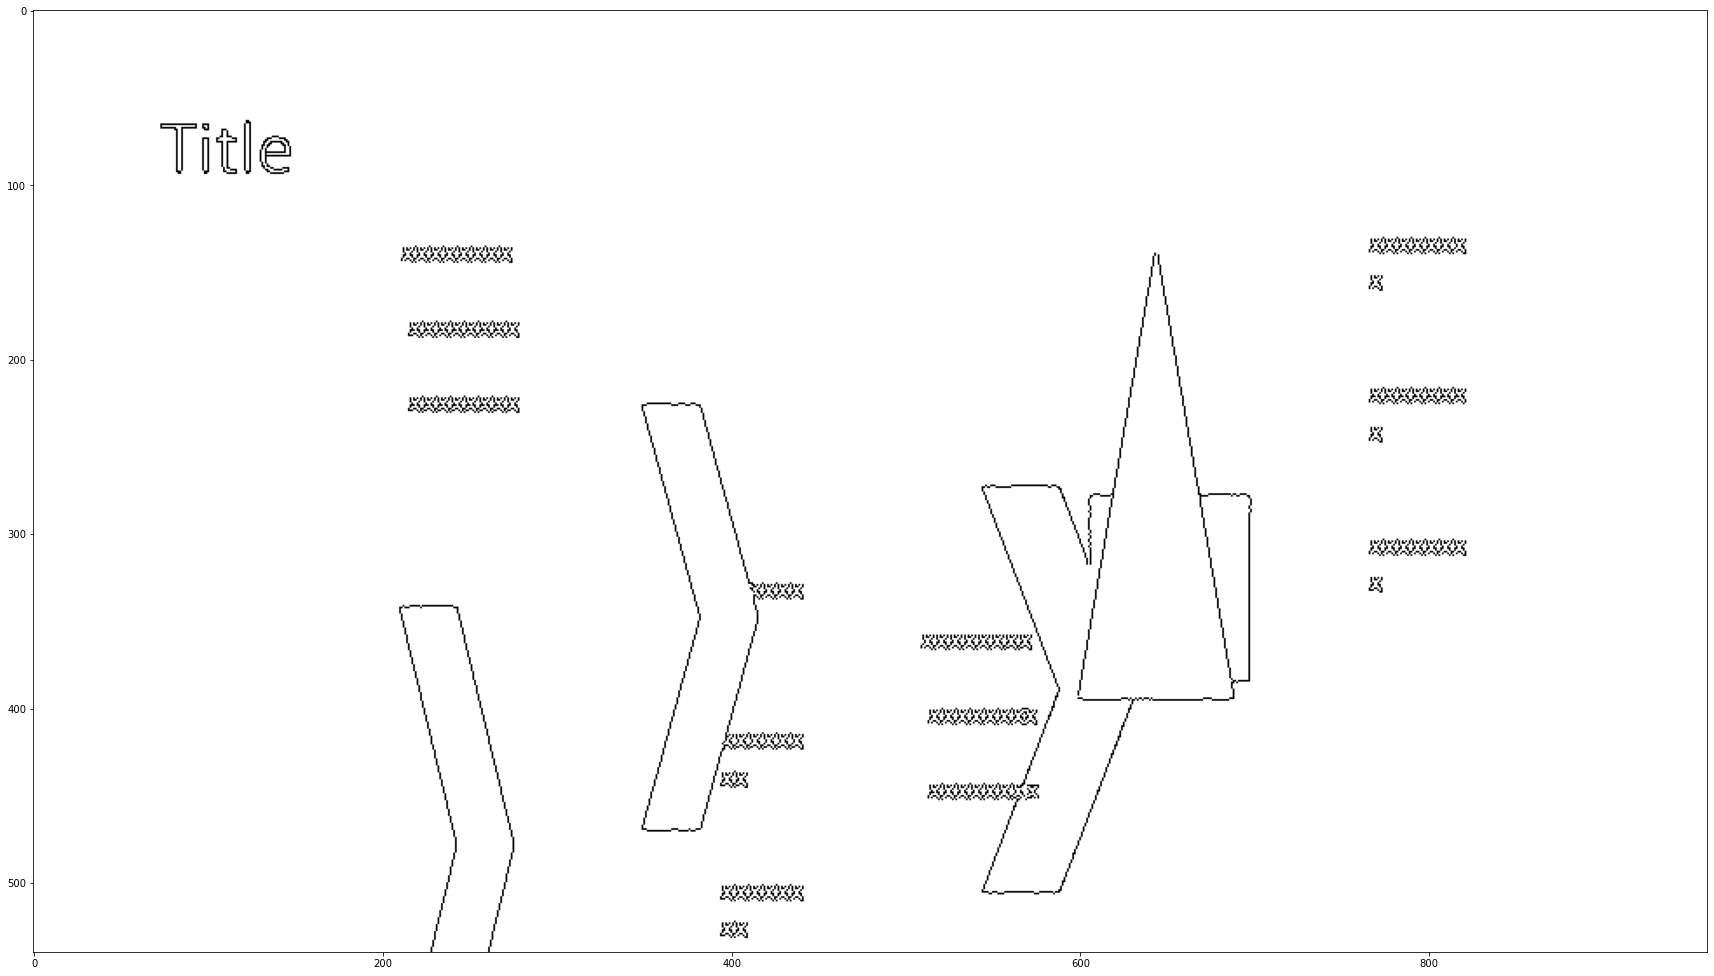

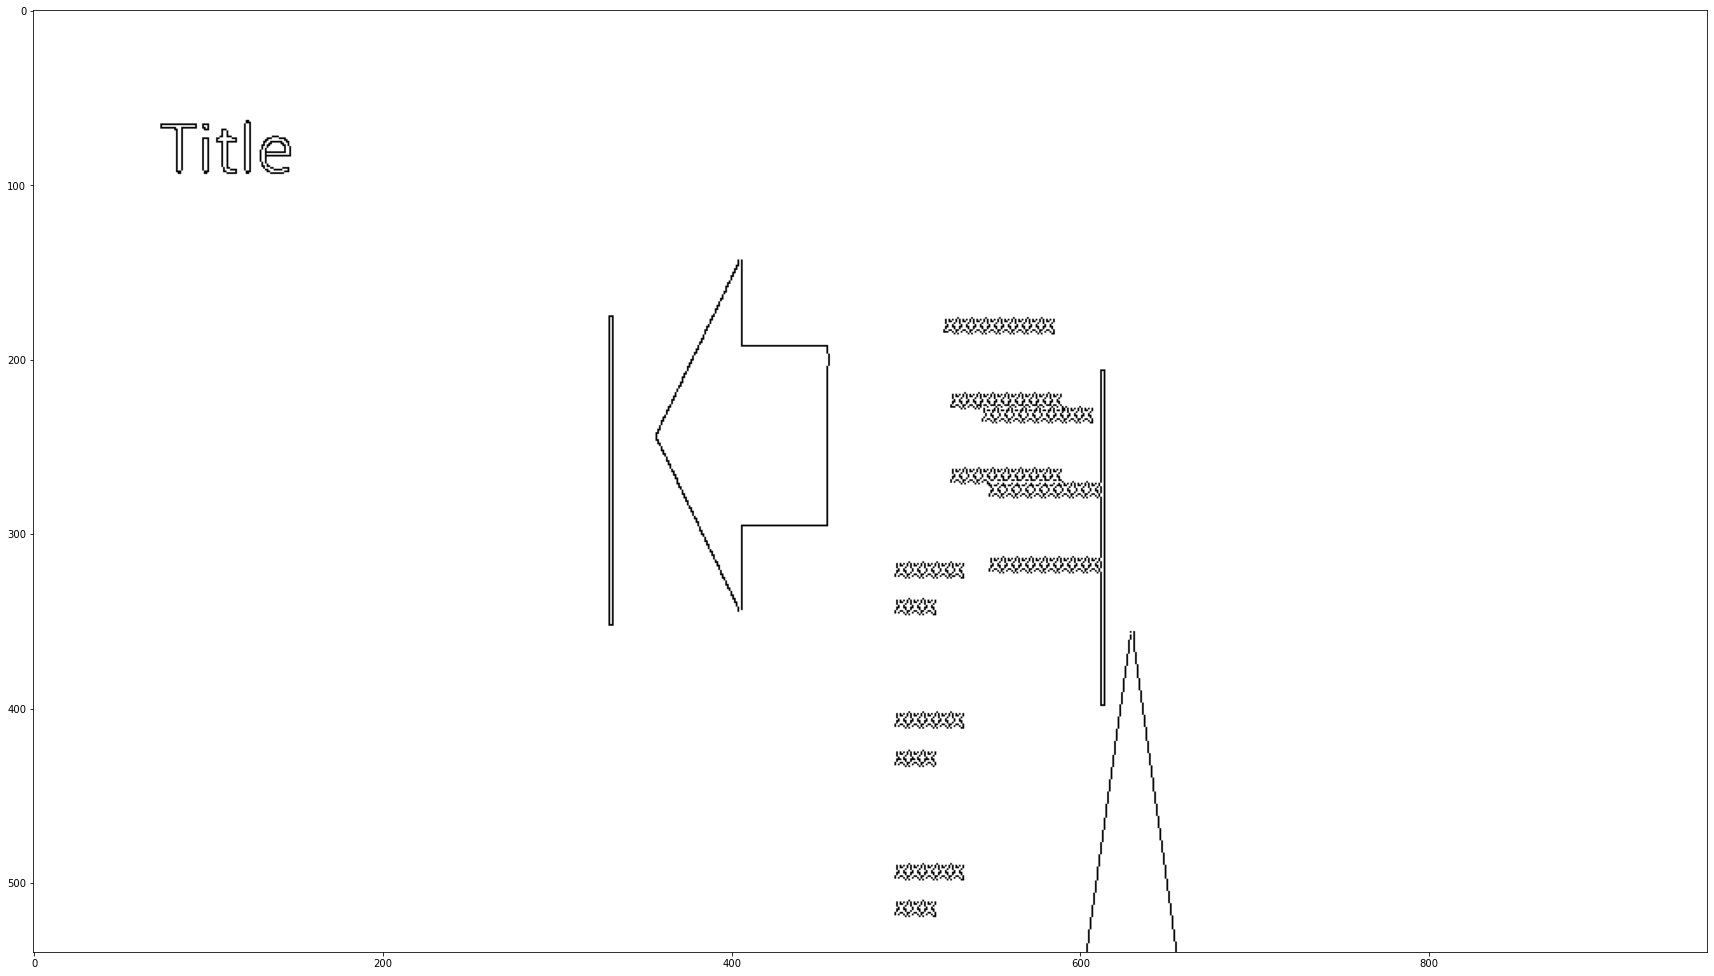

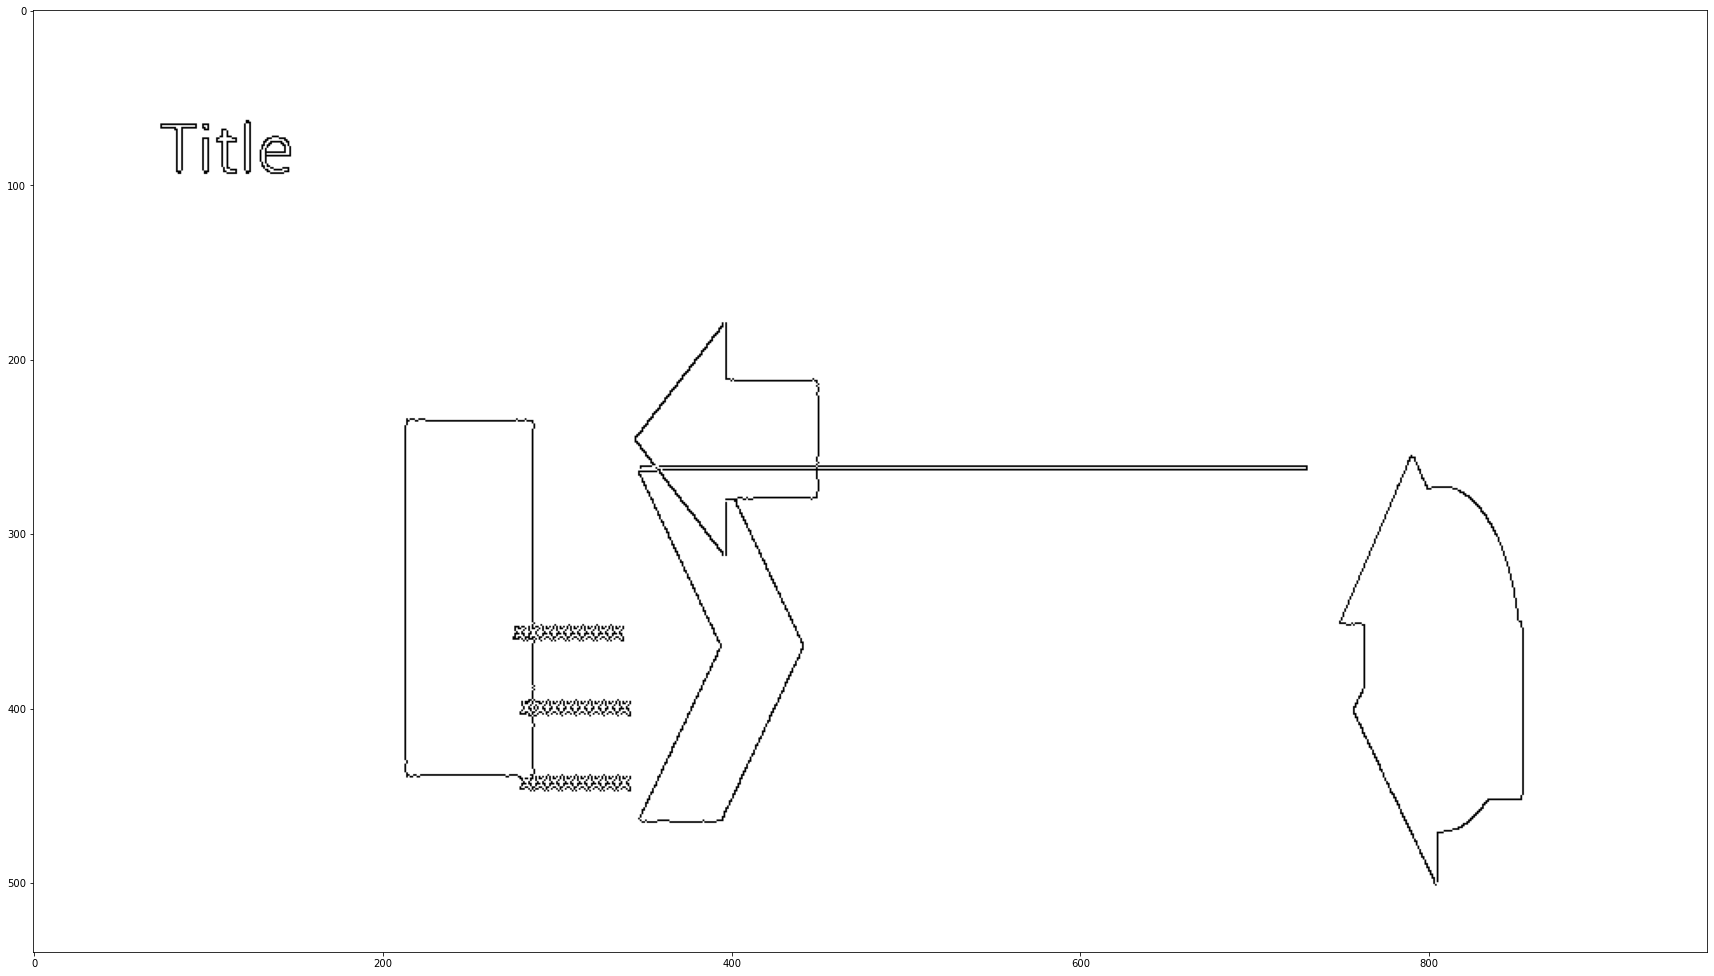

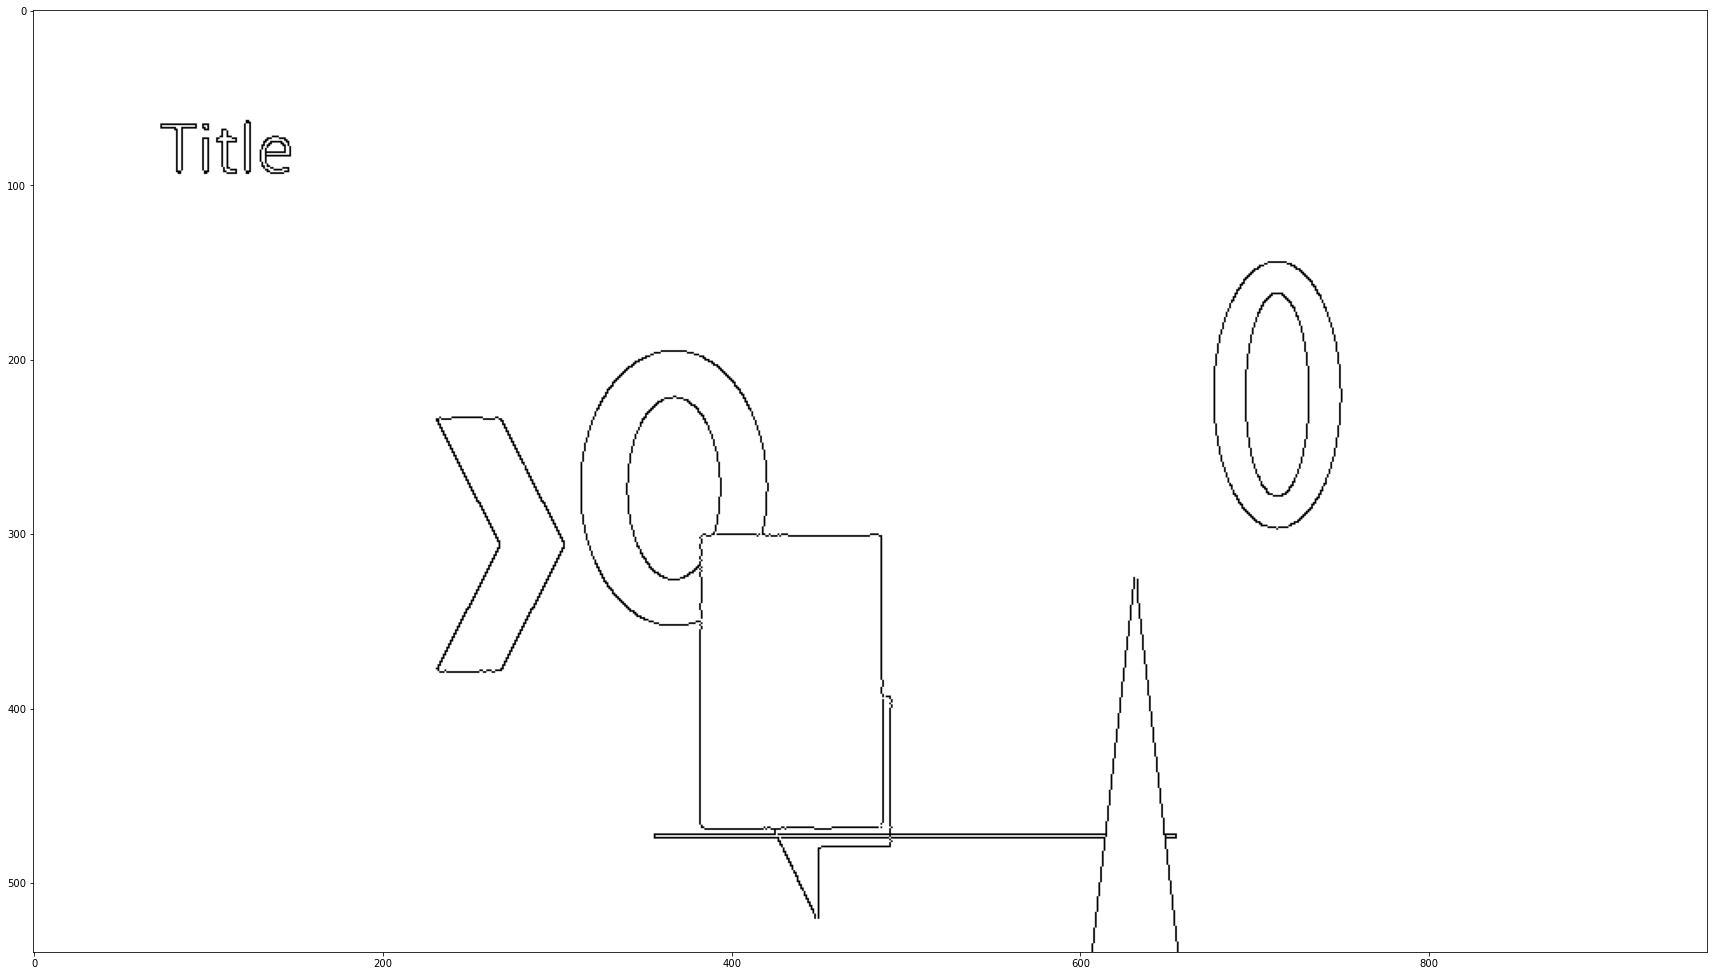

In [34]:

for i in range(0, 30):
    f = f'{DATA_BASE}/train//' + os.listdir(f'{DATA_BASE}/train')[i]
    img = cv2.imread(f)
    plt.figure(figsize=(30,20))
    plt.imshow(255 - cv2.Canny(img,100,200), cmap = 'gray')
    plt.show()

In [14]:
import cv2

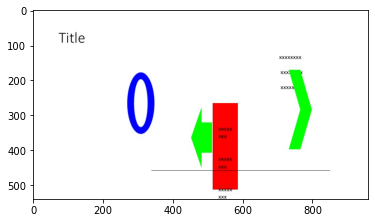

In [16]:
plt.imshow(img)

In [17]:
inverted_img = 255-cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
blurred_img = 255-cv2.GaussianBlur(inverted_img, (21,21), 0)

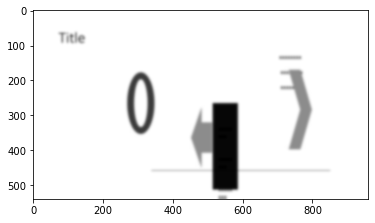

In [21]:
plt.imshow(blurred_img, cmap='gray')

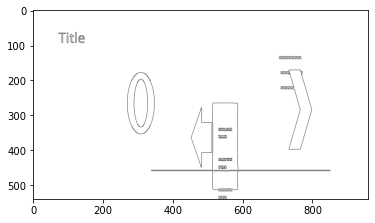